In [64]:
import os
import xugrid as xu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
#import 
%matplotlib inline

In [65]:
base_path = r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\04_modelruns'

model_names = ['21_25_April_2025_Base_case','21_25_April_2025_3m_surge','21_25_April_2025_dt_minus_10','21_25_April_2025_dt_plus_10']

base_name = model_names[0]
observed_names = model_names[1:]

# Paths to NetCDF history files
his_filepaths = [os.path.join(base_path, name, 'hurrywave_his.nc') for name in model_names]
map_filepaths = [os.path.join(base_path, name, 'hurrywave_map.nc') for name in model_names]


# Optional: Read station names from .obs file
obs_filepath = os.path.join(base_path, model_names[0], 'hurrywave.obs')





In [66]:
def read_station_names_from_obs(file_path):
    names = []
    with open(file_path, 'r') as f:
        for line in f:
            if '#' in line:
                name = line.split('# ')[1].strip()
                names.append(name)
    return names

station_names= read_station_names_from_obs(obs_filepath)

In [67]:
print(station_names)

['Euro platform', 'Platform D15-A', 'Platform Hoorn Q1-A', 'North Cormorant', 'K13 Alpha', 'Platform F16-A', 'IJmuiden munitiestortplaats']


In [68]:
# --- Extract data using station names ---
def extract_data(ds: xr.Dataset, station_names):
    """
    Returns nested dictionary:
    data[station_name][variable_name] = values
    """
    station_dict = {}
    for i, station_idx in enumerate(ds.stations.values):
        station_name = station_names[i]
        station_data = ds.sel(stations=station_idx)
        station_dict[station_name] = {}

        for var in ds.data_vars:
            station_dict[station_name][var] = station_data[var].values

        for coord in ds.coords:
            station_dict[station_name][coord] = station_data[coord].values

    return station_dict

# --- Master structure: data[model_name][station_name][variable_name] ---
data = {}

for model_name, file_path in zip(model_names, his_filepaths):
    ds = xr.open_dataset(file_path)
    data[model_name] = extract_data(ds, station_names)

In [69]:
print(data['21_25_April_2025_Base_case']['Euro platform'].keys())

dict_keys(['inp', 'station_id', 'station_name', 'station_x', 'station_y', 'station_z', 'crs', 'point_hm0', 'point_tp', 'point_wavdir', 'point_dirspr', 'wind_speed', 'wind_direction', 'total_runtime', 'average_dt', 'time'])


In [77]:
def plot_station_models_comparison(
    station_name,
    model_df,
    model_vars=None,
    models_to_plot=None
):
    """
    Plot time series for selected variables at a single station across multiple models.

    Parameters:
        station_name (str): Name of the station to plot.
        model_df (dict): Nested dict model[station][variable] = values.
                         Structure: model_df[model][station][variable]
        model_vars (list): Variable names to include in the plot.
        models_to_plot (list): List of model names to plot. If None, plot all.
    """
    # Use first model to auto-detect variables if not provided
    example_model = next(iter(model_df))
    if model_vars is None:
        model_vars = list(model_df[example_model].get(station_name, {}).keys())

    if models_to_plot is None:
        models_to_plot = list(model_df.keys())

    n_vars = len(model_vars)

    fig = plt.figure(figsize=(14, 4 * n_vars + 5))
    fig.suptitle(f'Model Comparison at {station_name}', fontsize=16, y=1.03)  # Increased y for more space

    # --- Map plot with station location ---
    map_ax = fig.add_axes([0.15, 0.82, 0.7, 0.16])
    m = Basemap(projection='merc', llcrnrlat=50, urcrnrlat=65,
                llcrnrlon=-5, urcrnrlon=10, resolution='i', ax=map_ax)
    m.drawcoastlines()
    m.fillcontinents(color='lightgray', lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')

    # Use lat/lon from the first model
    lat = float(model_df[example_model][station_name]["station_y"])
    lon = float(model_df[example_model][station_name]["station_x"])
    x, y = m(lon, lat)
    m.plot(x, y, 'ro', markersize=8)
    map_ax.text(x, y, f' {station_name}', fontsize=10, color='black')

    # --- Time series plots ---
    for i, var in enumerate(model_vars):
        ax = fig.add_axes([0.10, 0.60 - i * 0.22, 0.85, 0.18])
        ax.grid(True)

        for model_name in models_to_plot:
            station_data = model_df.get(model_name, {})
            if station_name in station_data and var in station_data[station_name]:
                time = station_data[station_name]["time"]
                values = station_data[station_name][var]
                ax.plot(time, values, label=model_name)

        ax.set_title(var)
        ax.set_ylabel(var)
        if i == len(model_vars) - 1:
            ax.set_xlabel("Time")
        ax.legend()

    plt.show()

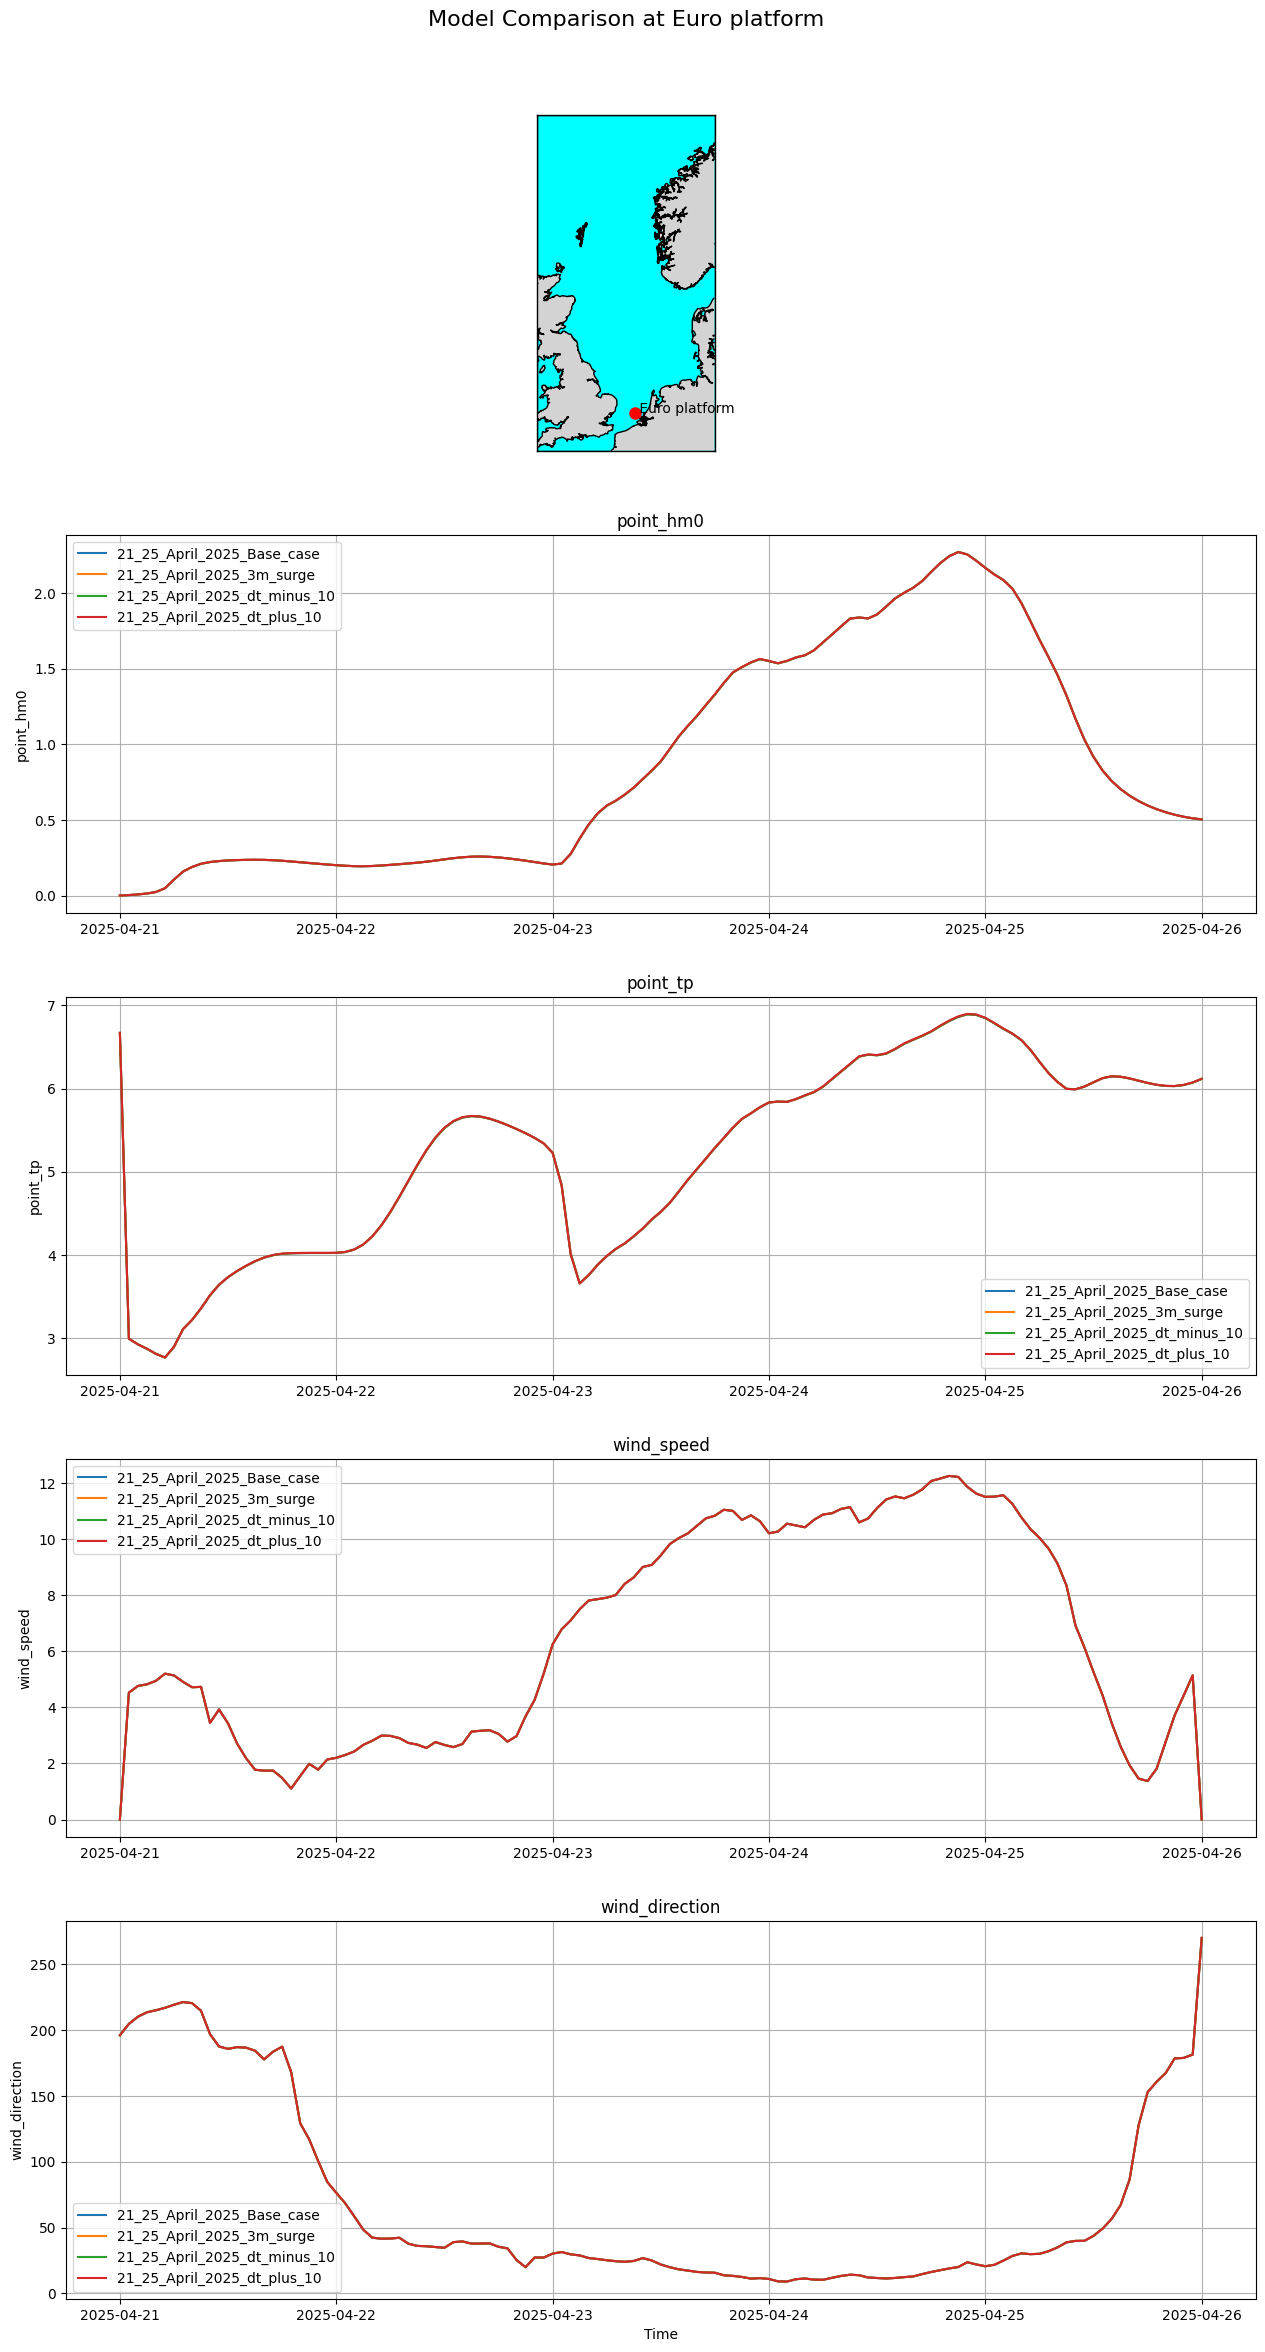

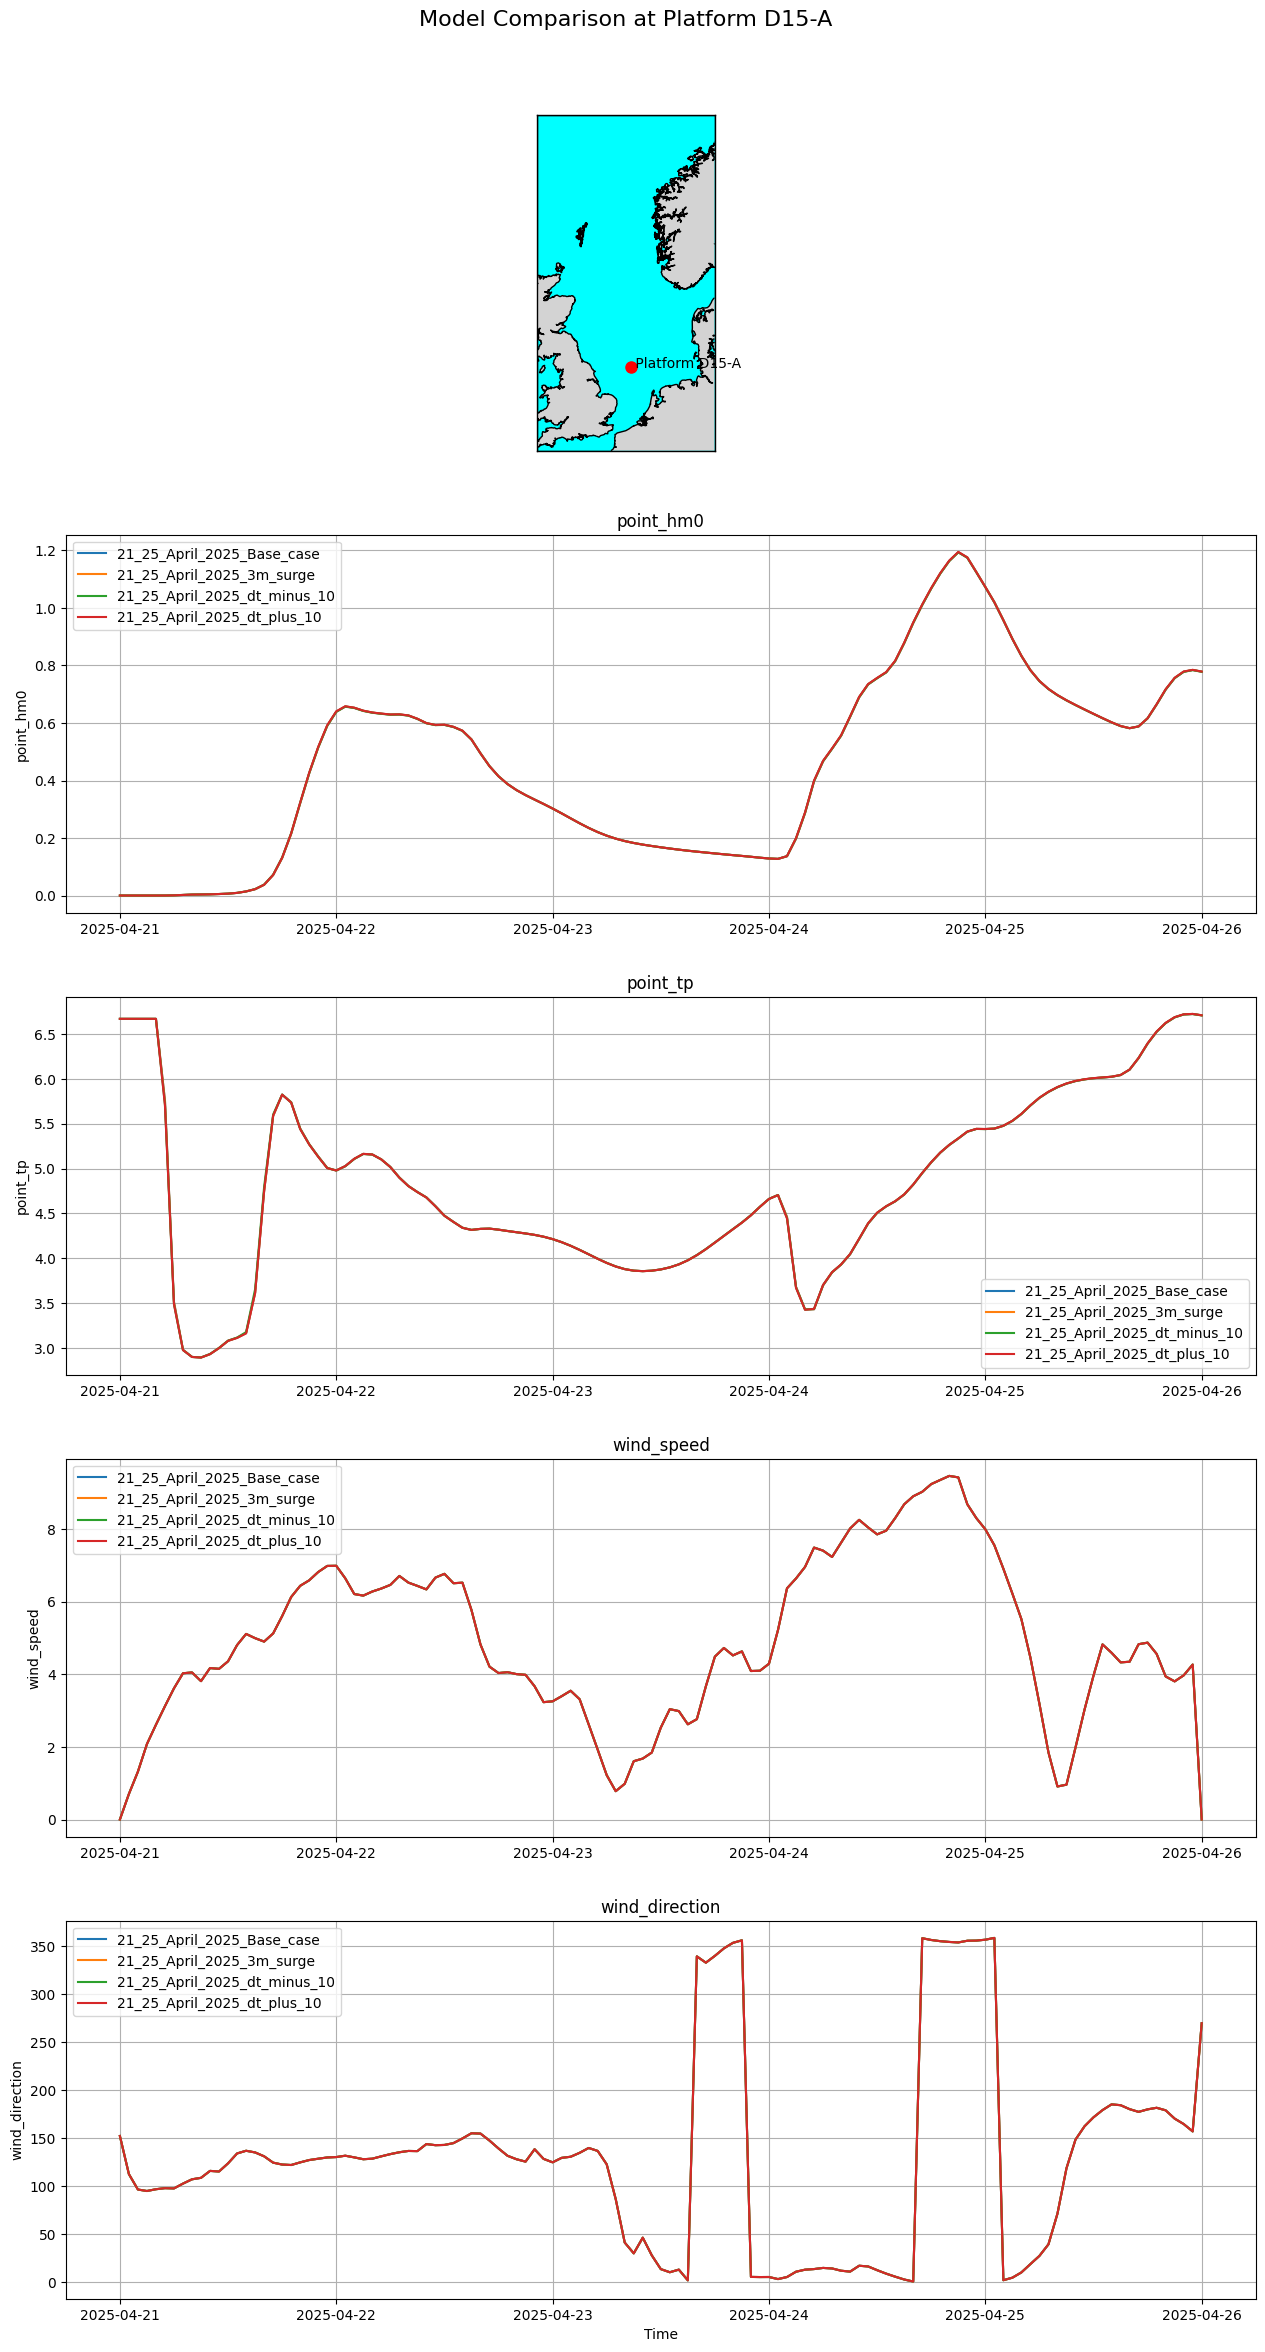

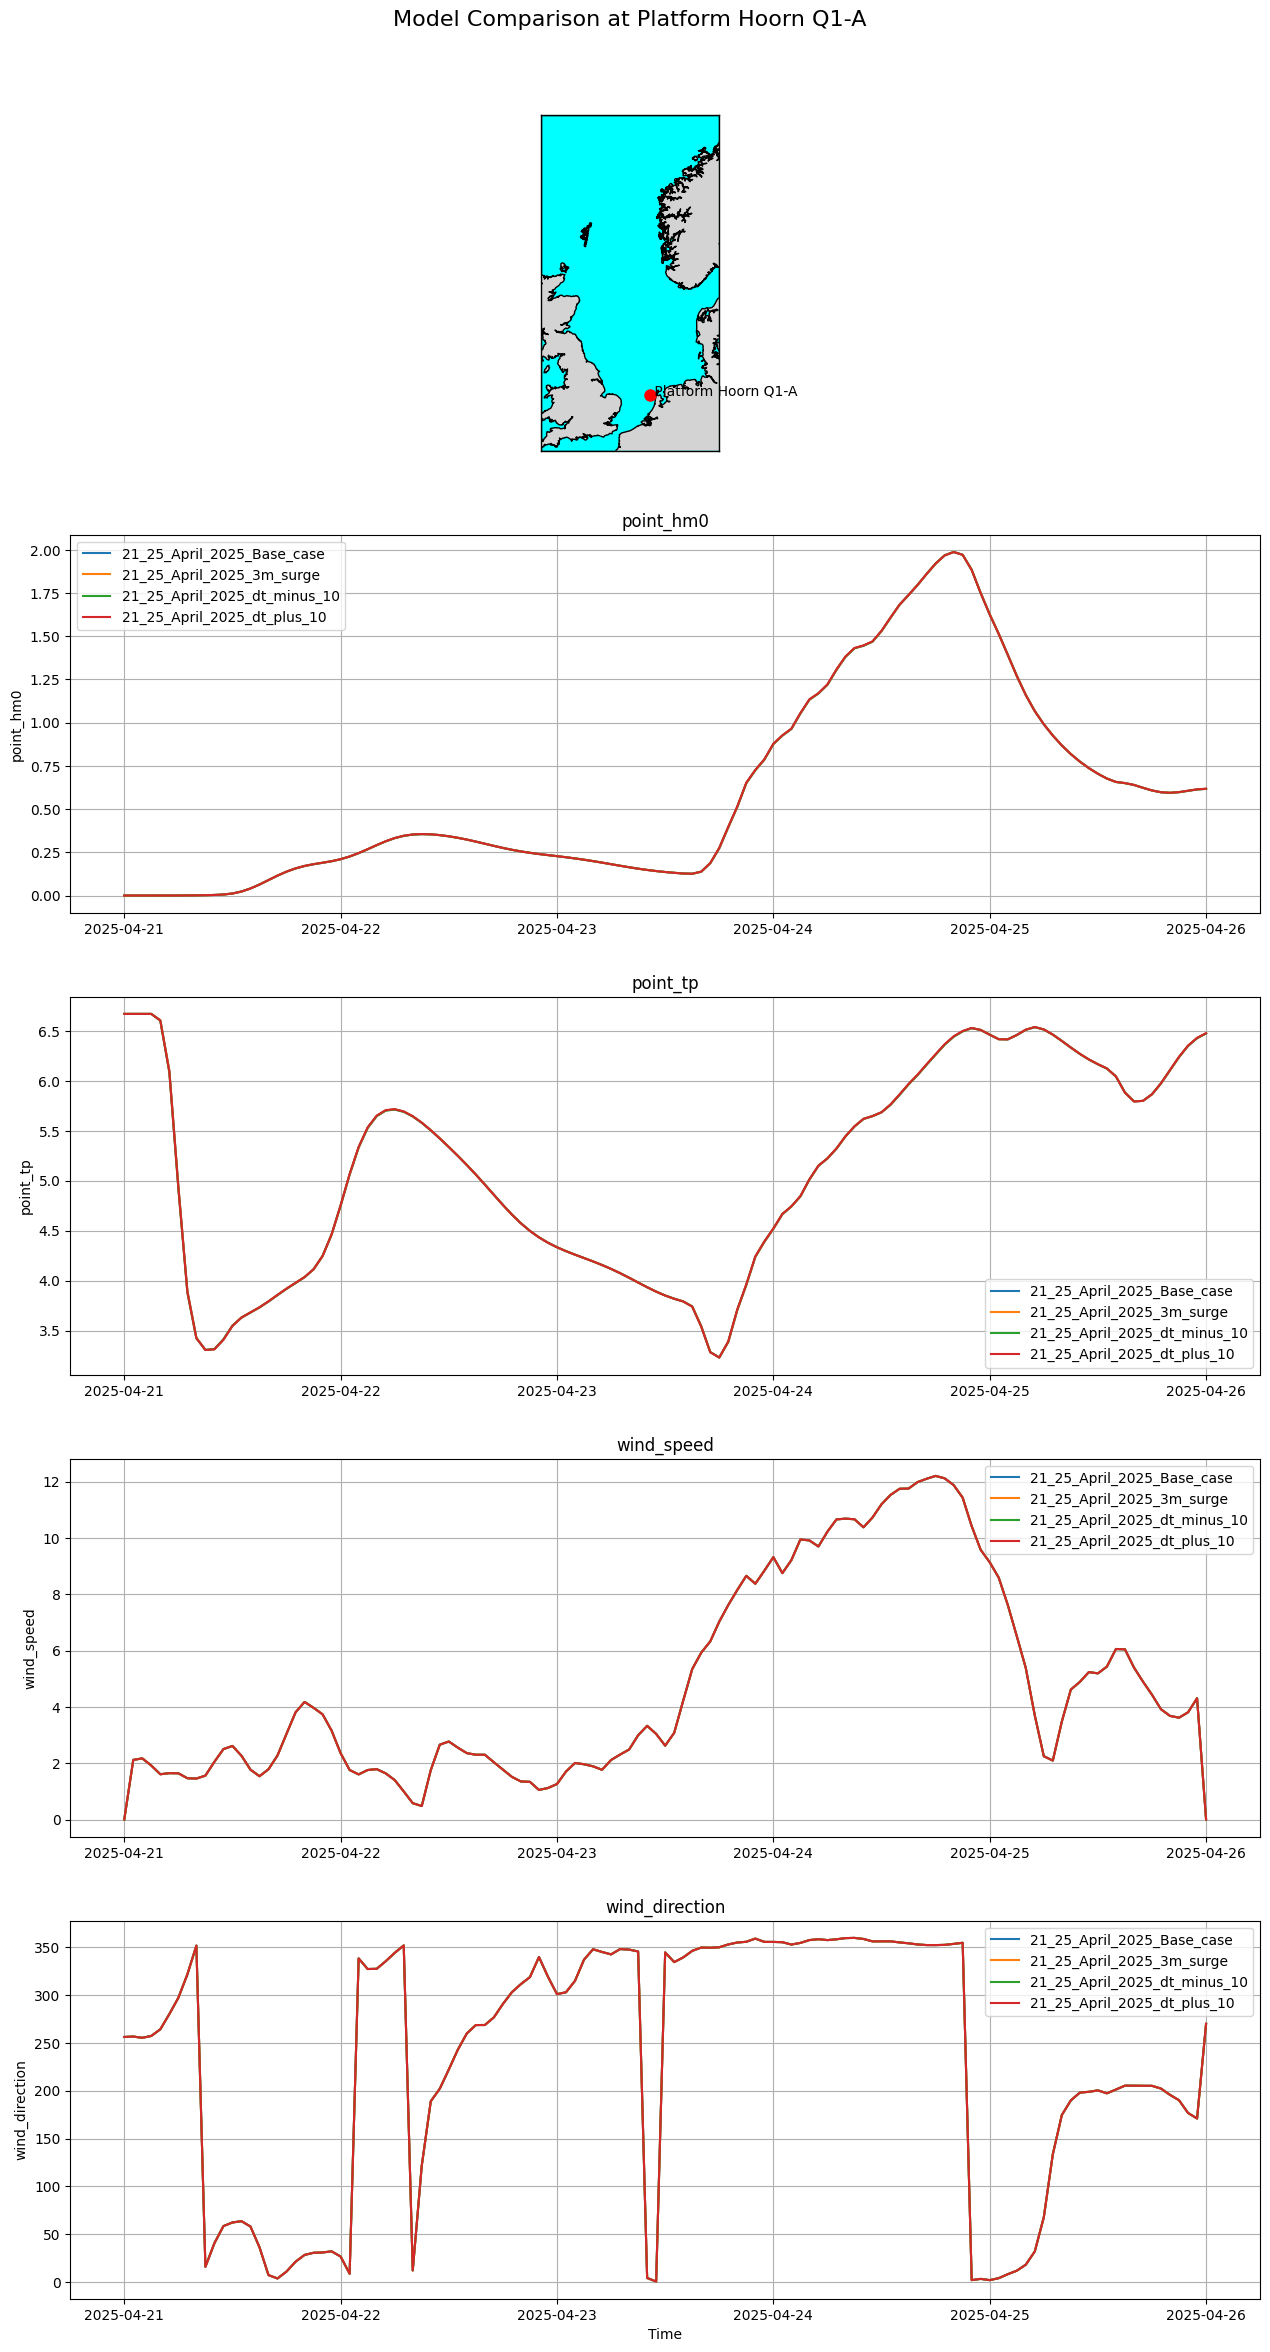

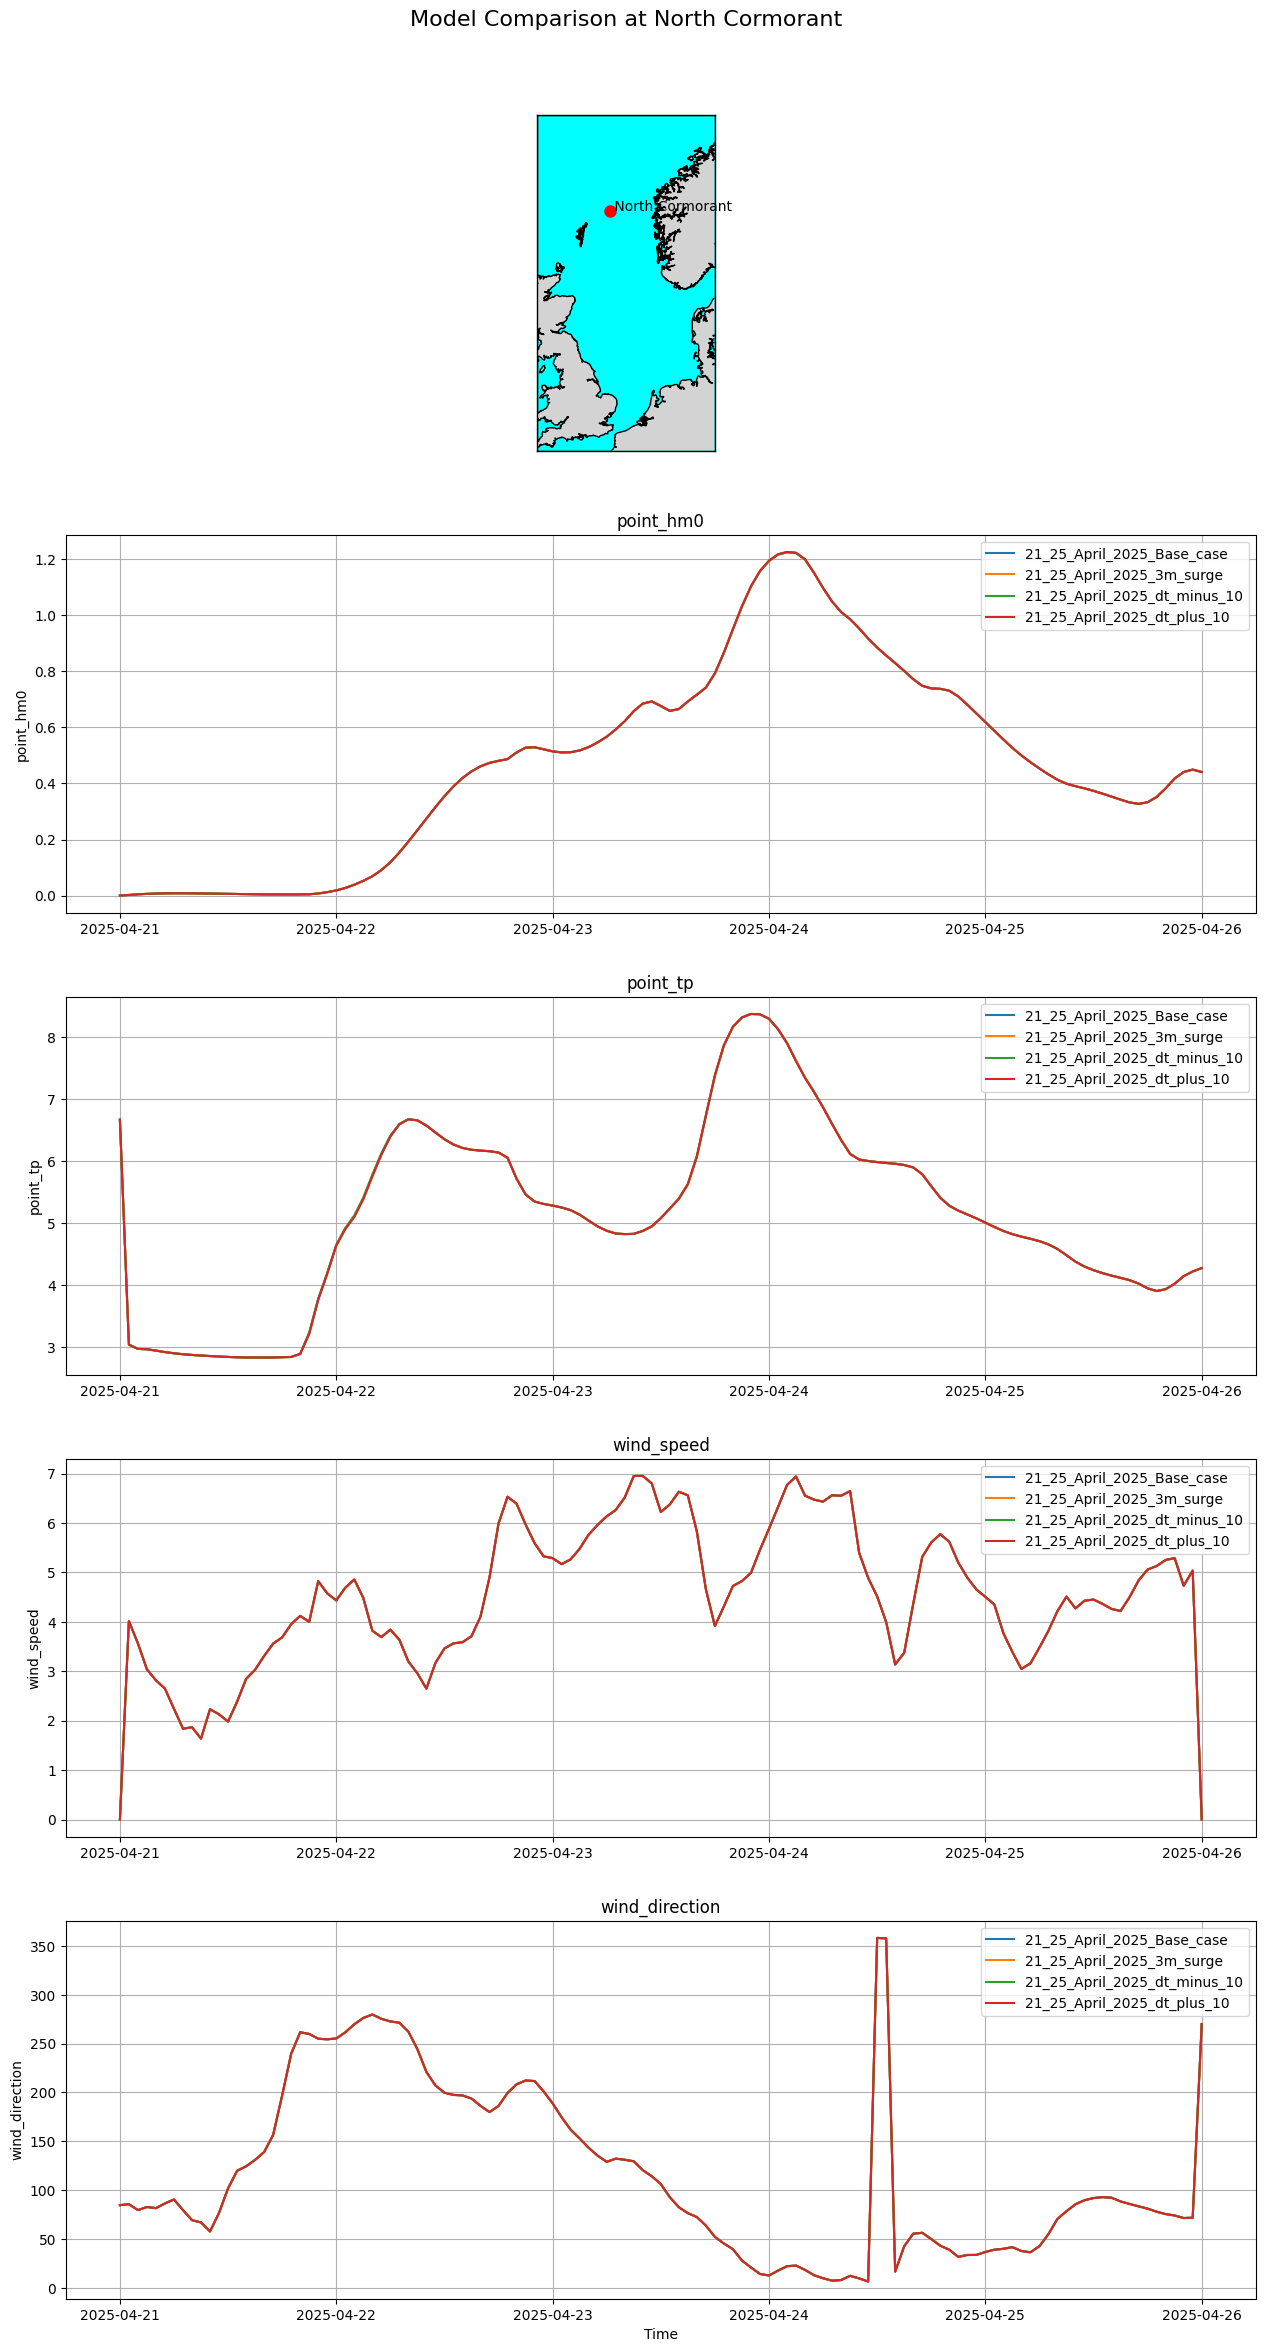

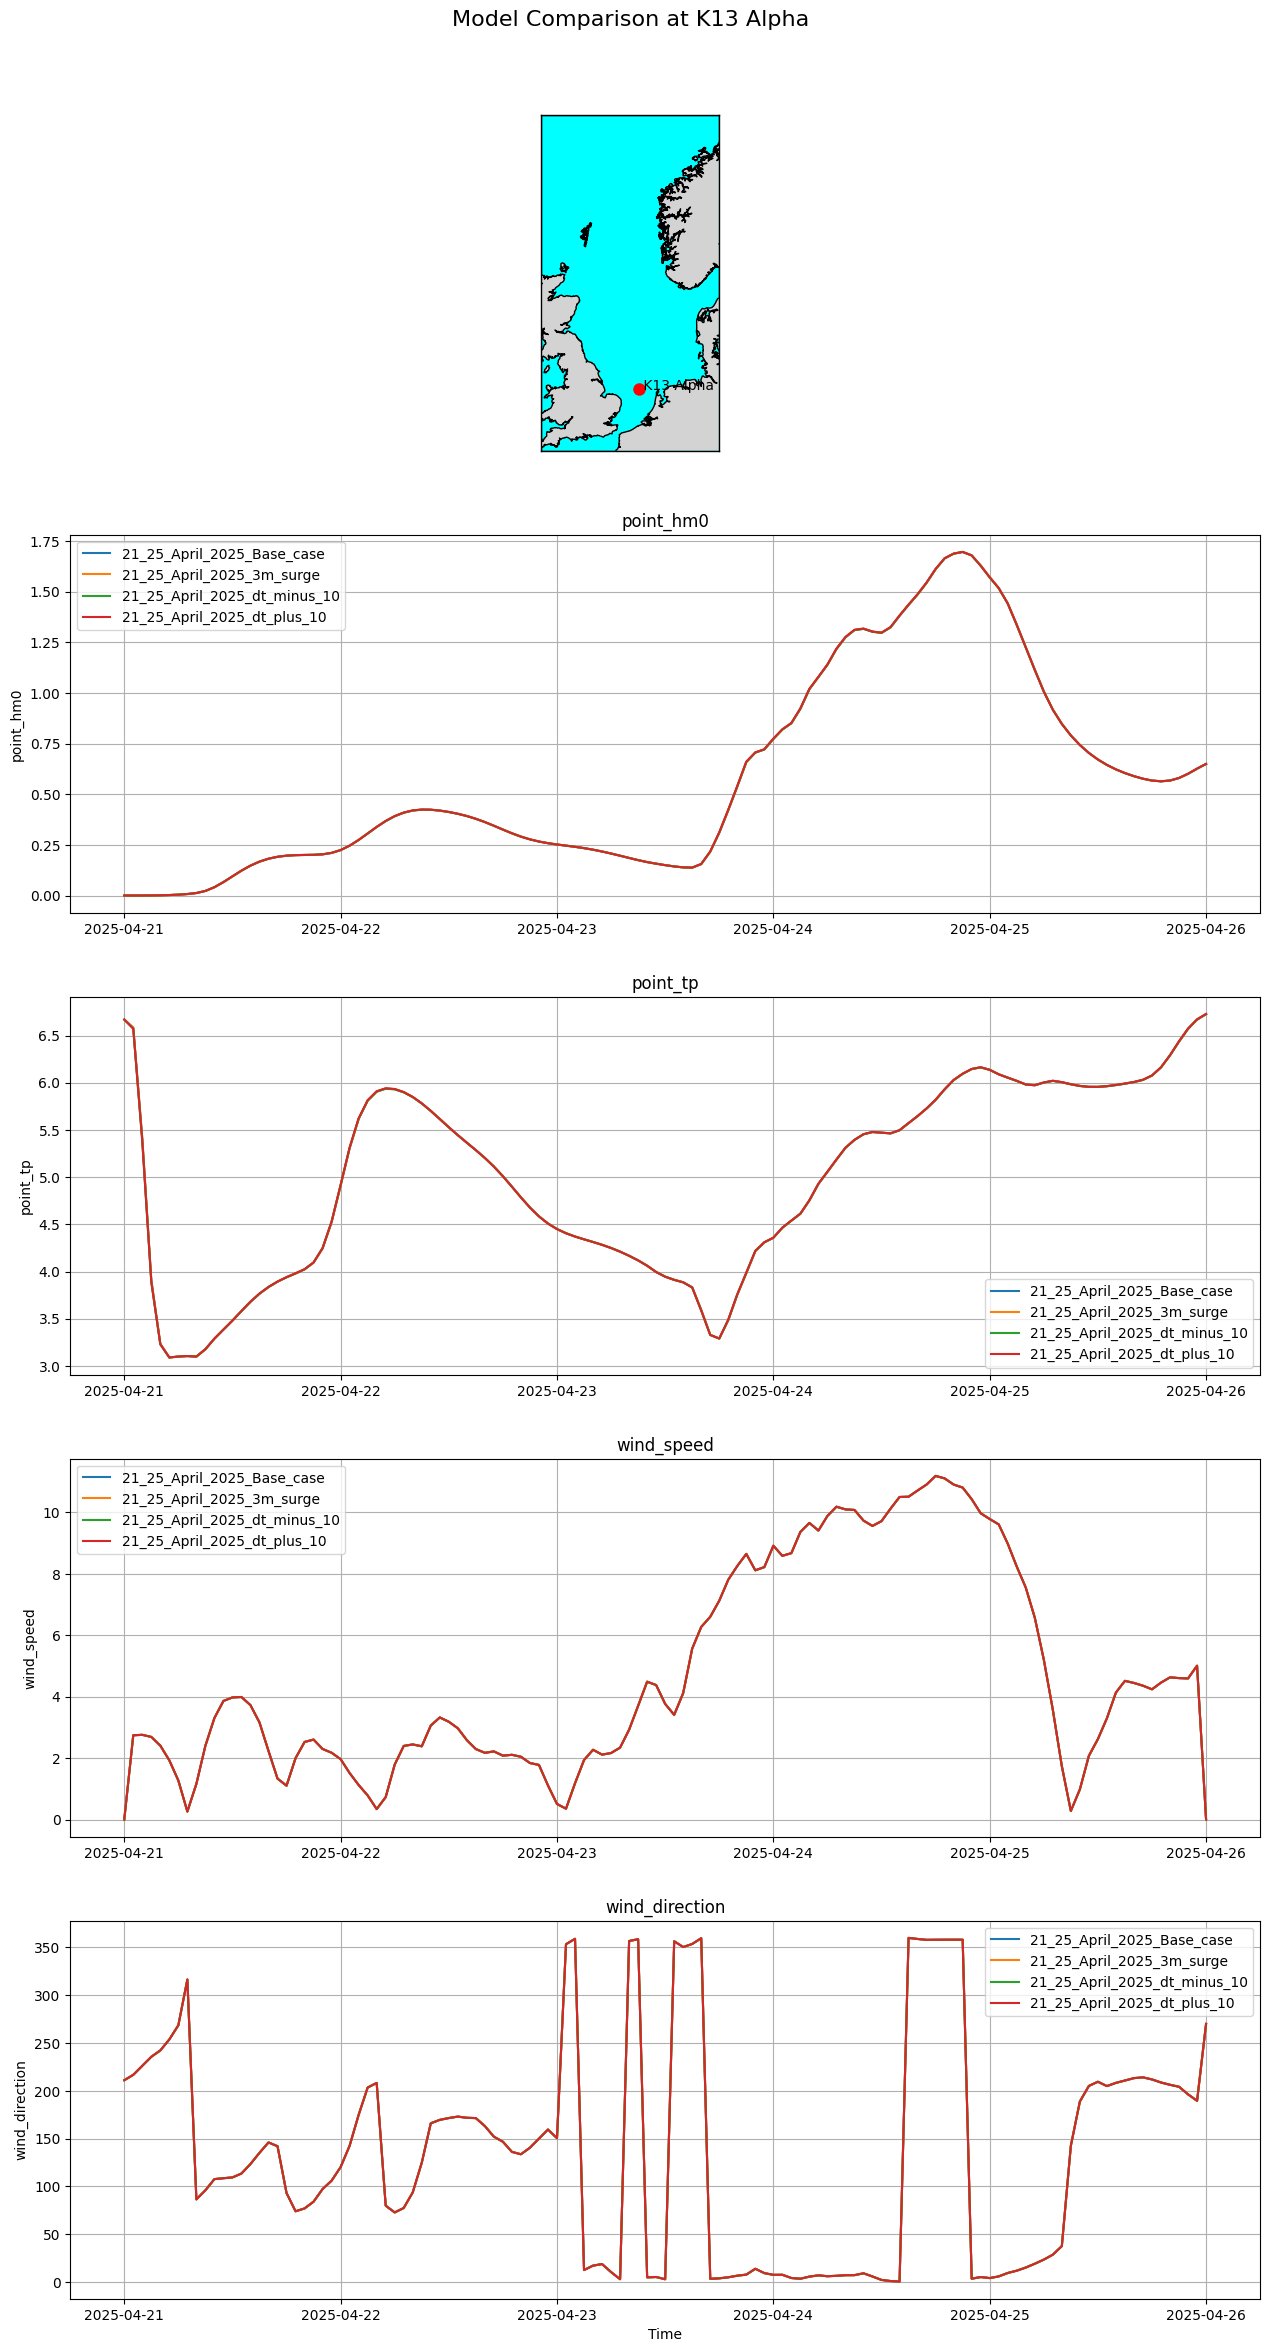

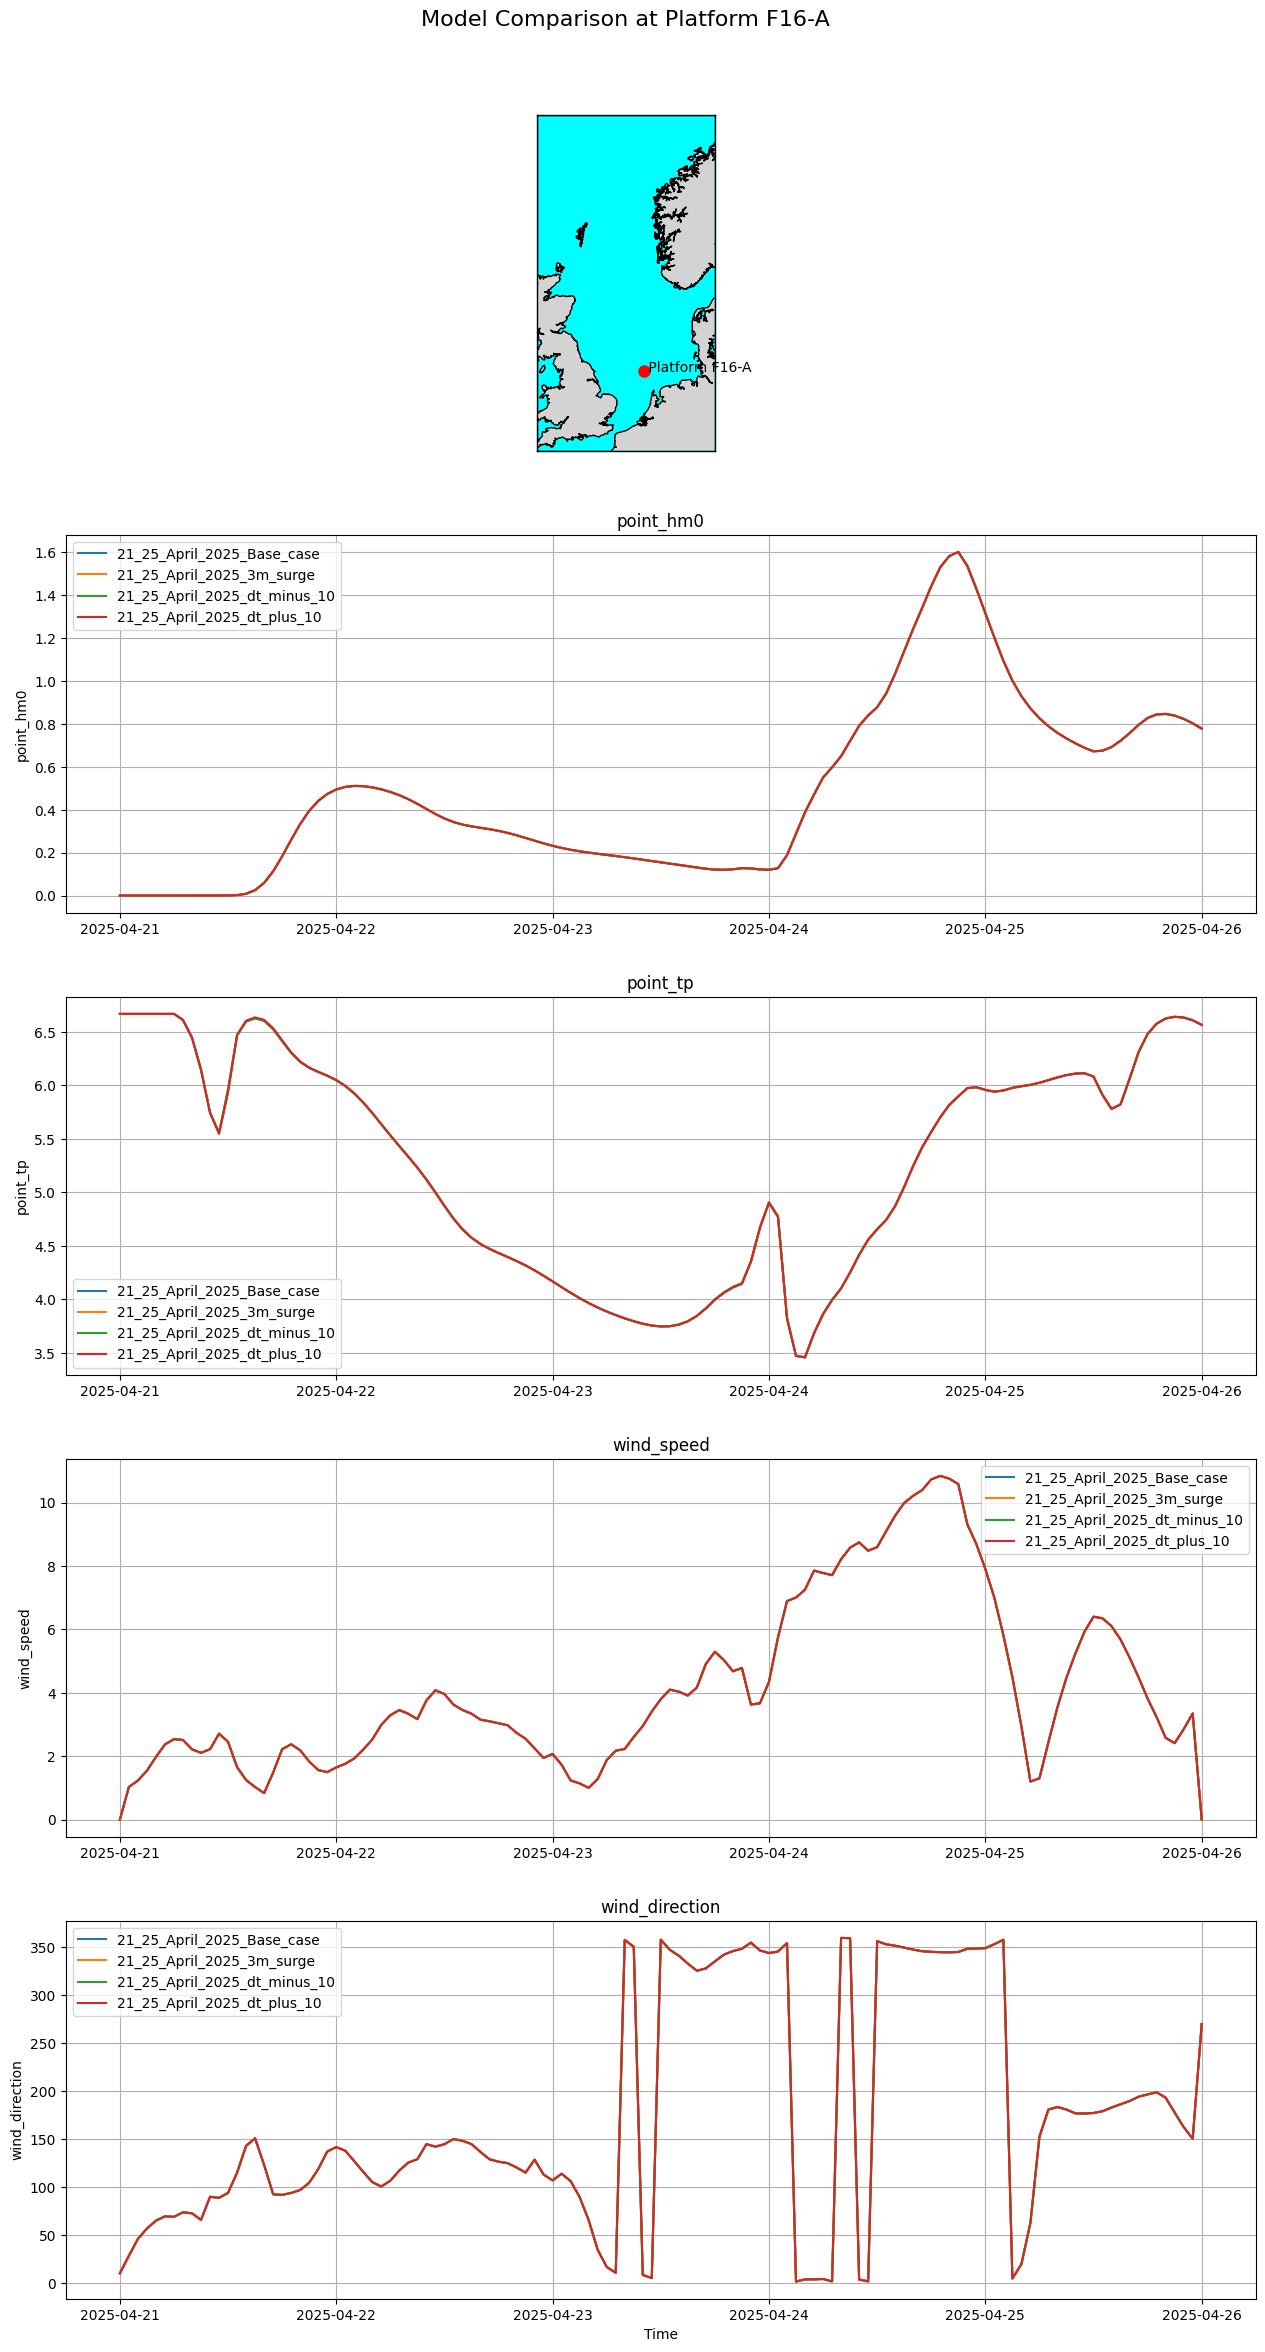

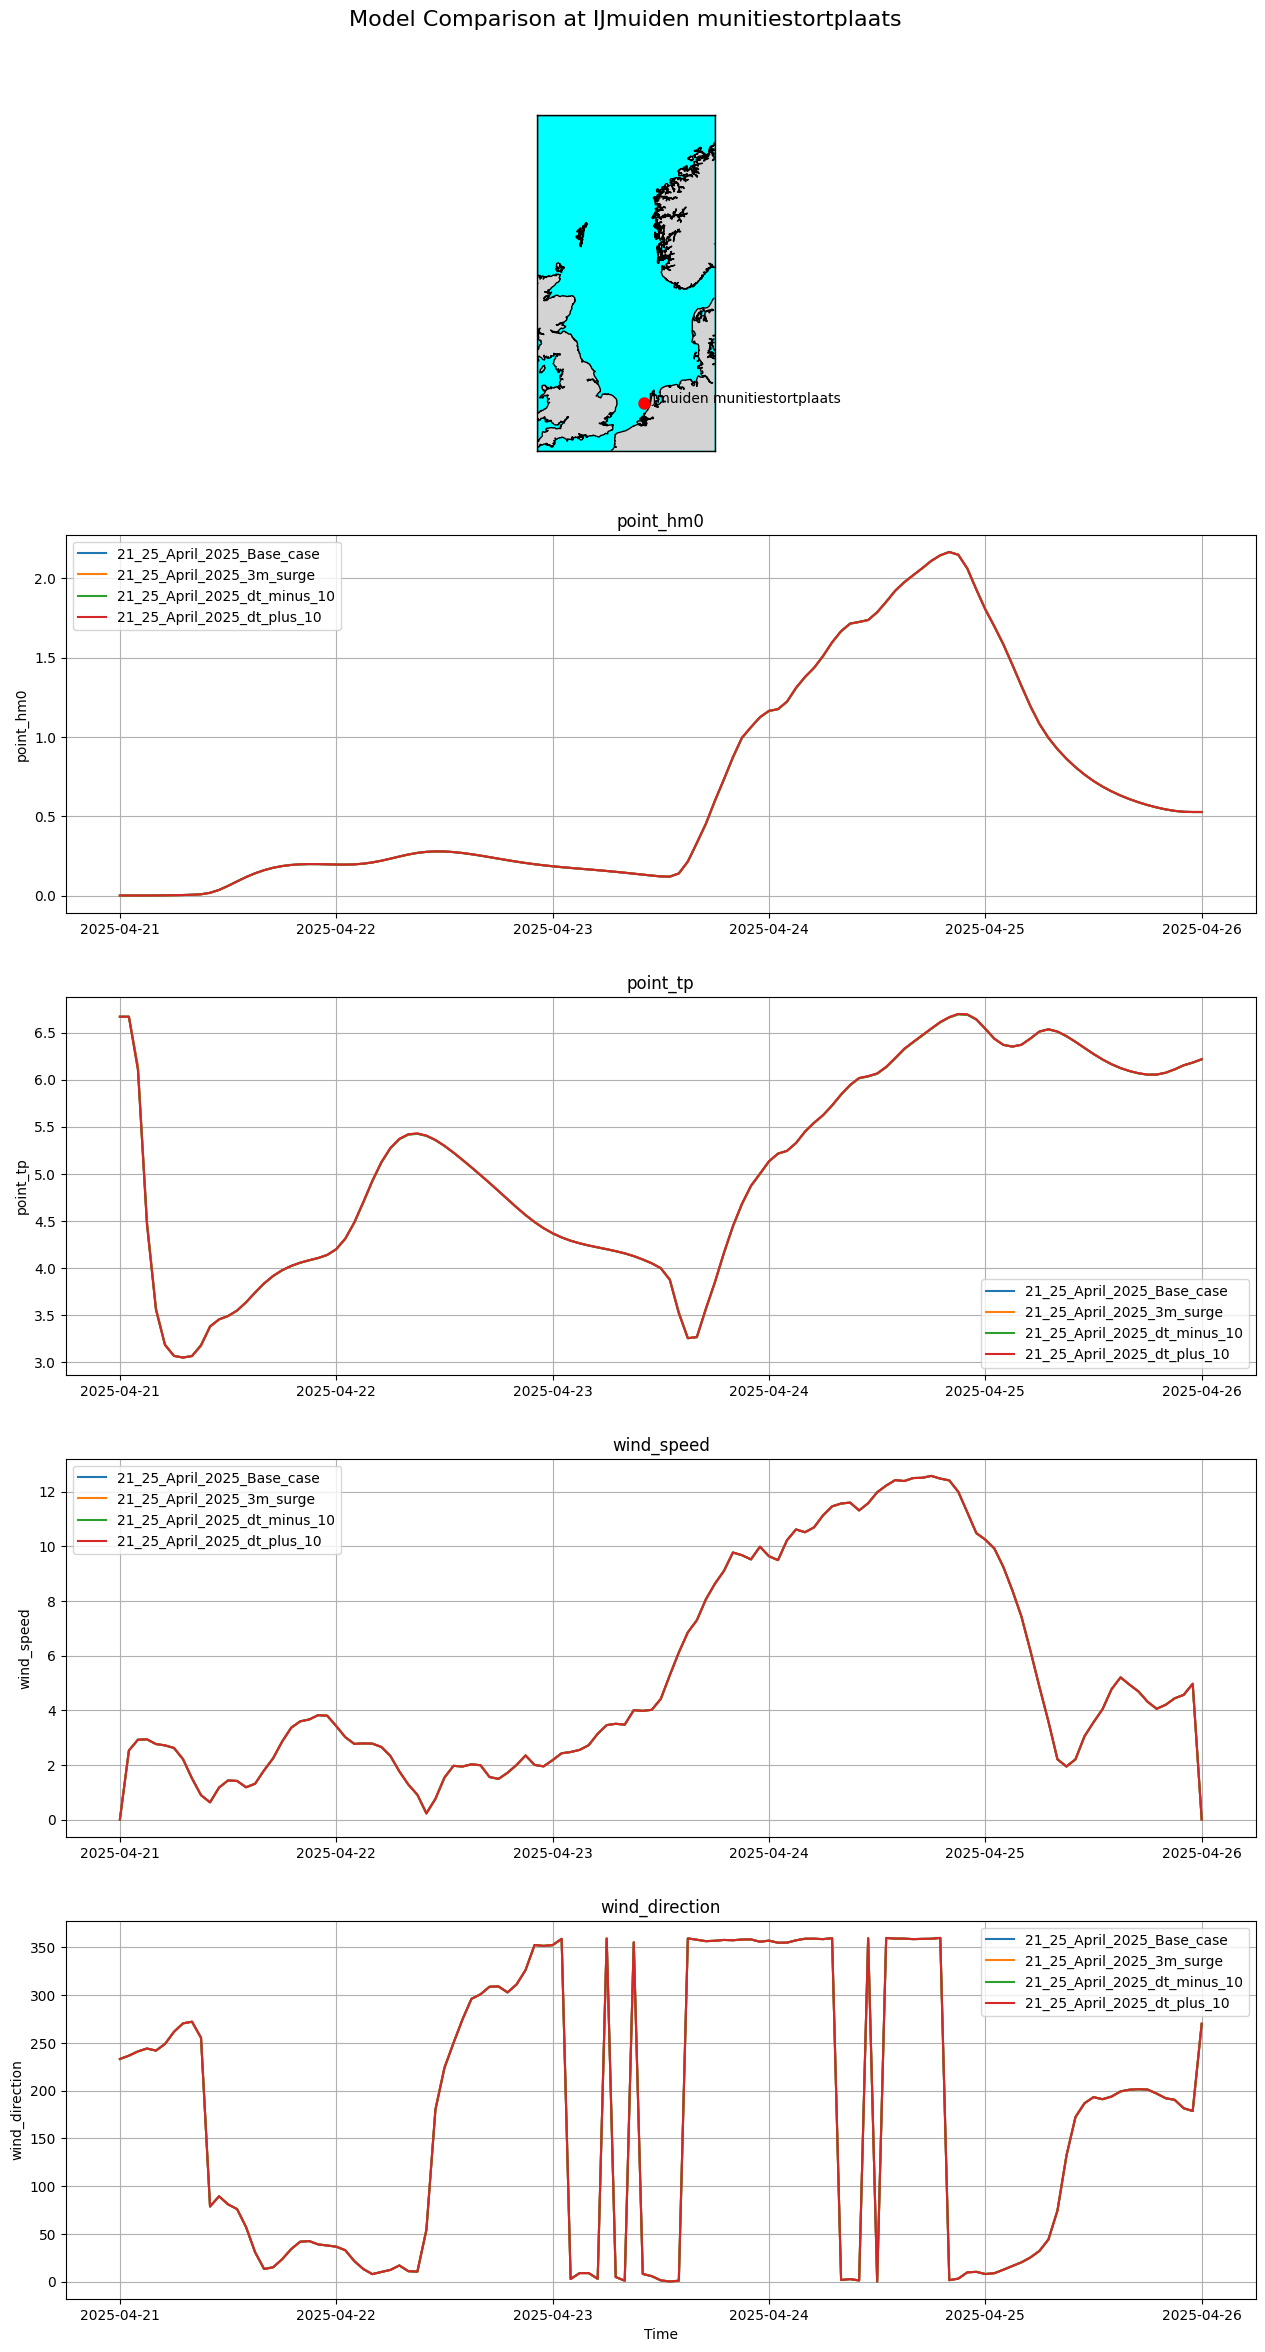

In [78]:
for station_name in station_names:
    plot_station_models_comparison(
        station_name=station_name,
        model_df=data,
        model_vars=["point_hm0", "point_tp", "wind_speed", "wind_direction"],  # or leave None to plot all
        models_to_plot=model_names # or leave None to plot all
    )

In [9]:
def rmse(obs, pred):
    """Root Mean Square Error"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    return np.sqrt(np.mean((pred - obs) ** 2))

def bias(obs, pred):
    """Mean Bias (Mean Error)"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    return np.mean(pred - obs)

def scatter_index(obs, pred):
    """Scatter Index: RMSE normalized by mean of observations"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    return rmse(obs, pred) / np.mean(obs)

def pinball_loss(obs, pred, quantile_pinball=0.5):
    """Pinball Loss Function for a given quantile (e.g., 0.5 for median)"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    delta = obs - pred
    return np.mean(np.maximum(quantile_pinball * delta, (quantile_pinball - 1) * delta))

def pinball_loss_from_list(obs, pred, quantile_pinball_list):
    """
    Compute pinball loss for a list of quantiles.
    
    Parameters:
        obs: array-like, observed values
        pred: array-like, predicted values
        quantile_pinball_list: list of quantiles (floats between 0 and 1)
        
    Returns:
        list of pinball losses, one for each quantile
    """
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    losses = []
    for q in quantile_pinball_list:
        delta = obs - pred
        loss = np.mean(np.maximum(q * delta, (q - 1) * delta))
        losses.append(loss)
    return losses

def calculate_statistics(obs, pred,  quantile_pinball, print_stats=True):
    """Calculate RMSE, Bias, Scatter Index, and Pinball Loss for a given list of quantiles"""
    rmse_value = rmse(obs, pred) 
    bias_value = bias(obs, pred)
    scatter_index_value = scatter_index(obs, pred)
    pinball_loss_values = pinball_loss_from_list(obs, pred, quantile_pinball)

    # Print the statistics
    if print_stats:
        print(f"RMSE: {rmse_value:.4f}")
        print(f"Bias: {bias_value:.4f}")
        print(f"Scatter Index: {scatter_index_value:.4f}")
        for quantile, pinball_loss_value in zip(quantile_pinball, pinball_loss_values):
            print(f"Pinball Loss for quantile {quantile}: {pinball_loss_value:.4f}")

    return rmse_value, bias_value, scatter_index_value, pinball_loss_values

def compute_statistics_against_observations(model_dict, base_case_name, observed_case_names, quantile_pinball, variables):
    """
    Compare a base model to observed datasets using statistics, for selected variables only.

    Parameters:
    - model_dict: dict of model_name -> station -> variable -> values
    - base_case_name: str, name of the base model in model_dict
    - observed_case_names: list of str, names of observed datasets in model_dict
    - quantile_pinball: list of quantiles for pinball loss
    - variables: list of variable names to include in the analysis

    Returns:
    - df_statistics[observed_case][station][variable][statistic] = value
    """
    df_statistics = {}
    base_data = model_dict[base_case_name]

    for obs_name in observed_case_names:
        obs_data = model_dict[obs_name]
        df_statistics[obs_name] = {}

        for station in obs_data:
            if station not in base_data:
                continue  # Skip stations not present in base case
            df_statistics[obs_name][station] = {}

            for variable in variables:
                if variable not in obs_data[station] or variable not in base_data[station]:
                    continue  # Skip variables not present in both obs and base

                obs = obs_data[station][variable]
                pred = base_data[station][variable]

                rmse_val, bias_val, si_val, pinball_vals = calculate_statistics(
                    obs, pred, quantile_pinball=quantile_pinball, print_stats=False
                )

                df_statistics[obs_name][station][variable] = {
                    'RMSE': rmse_val,
                    'Bias': bias_val,
                    'Scatter Index': si_val,
                }

                for q, ploss in zip(quantile_pinball, pinball_vals):
                    df_statistics[obs_name][station][variable][f'Pinball Loss (q={q})'] = ploss

    return df_statistics

In [10]:
df_statistics = compute_statistics_against_observations(
    model_dict=data,
    base_case_name=base_name,
    observed_case_names=observed_names,
    quantile_pinball=[0.1, 0.5, 0.9],
    variables=["point_hm0", "point_tp"]
)

In [11]:
import pandas as pd
from IPython.display import display, HTML

# Prepare a table comparing statistics for each model run (columns) for all stations and variables (rows)

# Flatten df_statistics to a DataFrame
rows = []
for model_run, stations in df_statistics.items():
    for station, variables in stations.items():
        for variable, stats in variables.items():
            row = {
                'Model Run': model_run,
                'Station': station,
                'Variable': variable
            }
            row.update(stats)
            rows.append(row)

df_stats_table = pd.DataFrame(rows)

# Pivot the table: rows = (Station, Variable, Statistic), columns = Model Run
df_stats_long = df_stats_table.melt(
    id_vars=['Model Run', 'Station', 'Variable'],
    var_name='Statistic',
    value_name='Value'
)

df_stats_pivot = df_stats_long.pivot_table(
    index=['Station', 'Variable', 'Statistic'],
    columns='Model Run',
    values='Value'
)

# Display the table as a scrollable DataFrame

display(HTML(df_stats_pivot.to_html(max_rows=100, max_cols=10, notebook=True, border=1)))

# Map Data

In [ ]:
# Open base case and comparison model output (MAP) files
base_map_file = os.path.join(base_path, map_filepaths[0])
comp_map_file = os.path.join(base_path, map_filepaths[1])




In [ ]:
def plot_comparison_map(base_map_path, compared_map_path, plot_swh=True, plot_tp = True):
    base_nc = xu.open_dataset(base_map_path, decode_times=True)
    comp_nc = xu.open_dataset(compared_map_path, decode_times=True)

    base_name = os.path.basename(os.path.dirname(base_map_path))
    compared_name = os.path.basename(os.path.dirname(compared_map_path))

    # Use the same structure for both datasets
    base_modig = {
        "Hm0": base_nc["hm0"],
        "Tp": base_nc["tp"],
        "DIR": base_nc["wavdir"],
        "ds": base_nc["dirspr"],
        "msk": base_nc["msk"],
        "zb": base_nc["zb"]
    }
    comp_modig = {
        "Hm0": comp_nc["hm0"],
        "Tp": comp_nc["tp"],
        "DIR": comp_nc["wavdir"],
        "ds": comp_nc["dirspr"],
        "msk": comp_nc["msk"],
        "zb": comp_nc["zb"]
    }

    # Get coordinates
    model_x = base_nc['x']
    model_y = base_nc['y']

    # 1. Match times once
    base_times = base_modig['Hm0']['time'].values
    comp_times = comp_modig['Hm0']['time'].values
    _, base_idx, comp_idx = np.intersect1d(base_times, comp_times, return_indices=True)

    # 2. Subset data based on matched times
    base_hm0 = base_modig['Hm0'].isel(time=base_idx).values  # shape: [T, i, j]
    comp_hm0 = comp_modig['Hm0'].isel(time=comp_idx).values

    base_tp = base_modig['Tp'].isel(time=base_idx).values
    comp_tp = comp_modig['Tp'].isel(time=comp_idx).values

    # 3. Compute statistics in one go
    valid_mask_hm0 = np.isfinite(base_hm0) & np.isfinite(comp_hm0)
    valid_mask_tp = np.isfinite(base_tp) & np.isfinite(comp_tp)

    # Replace invalid values with NaN
    base_hm0[~valid_mask_hm0] = np.nan
    comp_hm0[~valid_mask_hm0] = np.nan
    base_tp[~valid_mask_tp] = np.nan
    comp_tp[~valid_mask_tp] = np.nan

    # RMSE
    rmse_map_swh = np.sqrt(np.nanmean((comp_hm0 - base_hm0)**2, axis=0))
    rmse_map_tp = np.sqrt(np.nanmean((comp_tp - base_tp)**2, axis=0))

    # Scatter index
    scatter_index_map_swh = rmse_map_swh / np.nanmean(base_hm0, axis=0)
    scatter_index_map_tp = rmse_map_tp / np.nanmean(base_tp, axis=0)

    # Bias
    bias_map_swh = np.nanmean(comp_hm0 - base_hm0, axis=0)
    bias_map_tp = np.nanmean(comp_tp - base_tp, axis=0)

    if plot_swh:
        fig, axs = plt.subplots(1, 3, figsize=(22, 7), constrained_layout=True)

        # Add a title above the subplots
        fig.suptitle(
            f"Comparison of significant wave height between {base_name} and {compared_name}",
            fontsize=18, fontweight='bold', y=1.05
        )

        # --- RMSE map ---
        ax = axs[0]
        m_rmse = Basemap(projection='merc',
                llcrnrlat=model_y.values.min(), urcrnrlat=model_y.values.max(),
                llcrnrlon=model_x.values.min(), urcrnrlon=model_x.values.max(),
                resolution='i', ax=ax)
        m_rmse.drawcoastlines()
        ax.set_facecolor('white')
        x_map, y_map = m_rmse(model_x.values, model_y.values)

        beige_to_red = LinearSegmentedColormap.from_list(
            "red-beige-red",
            [(0, "#f5f5dc"), (1, "#8b0000")]
        )

        im1 = m_rmse.pcolormesh(x_map, y_map, rmse_map_swh, cmap=beige_to_red, shading='auto', vmin=0, vmax=np.nanmax(rmse_map_swh))
        cbar1 = plt.colorbar(im1, ax=ax, orientation='vertical', pad=0.02)
        cbar1.set_label('RMSE [m]')
        ax.set_title('Hm0 RMSE between the runs')
        m_rmse.drawparallels(np.arange(np.floor(model_y.values.min()), np.ceil(model_y.values.max()), 2),
                    labels=[1,0,0,0], fontsize=10, linewidth=0.5)
        m_rmse.drawmeridians(np.arange(np.floor(model_x.values.min()), np.ceil(model_x.values.max()), 2),
                    labels=[0,0,0,1], fontsize=10, linewidth=0.5)
        ax.set_xlabel('Longitude [deg]', labelpad=25)  # Increased labelpad for more space
        ax.set_ylabel('Latitude [deg]', labelpad=40)   # Increased labelpad for more space

        # --- Scatter Index map ---
        ax = axs[1]
        m_si = Basemap(projection='merc',
                llcrnrlat=model_y.values.min(), urcrnrlat=model_y.values.max(),
                llcrnrlon=model_x.values.min(), urcrnrlon=model_x.values.max(),
                resolution='i', ax=ax)
        m_si.drawcoastlines()
        ax.set_facecolor('white')
        x_map, y_map = m_si(model_x.values, model_y.values)
        im2 = m_si.pcolormesh(x_map, y_map, scatter_index_map_swh, cmap=beige_to_red, shading='auto', vmin=0, vmax=np.nanmax(scatter_index_map_swh))
        cbar2 = plt.colorbar(im2, ax=ax, orientation='vertical', pad=0.02)
        cbar2.set_label('Scatter Index')
        ax.set_title('Hm0 Scatter Index between the runs')
        m_si.drawparallels(np.arange(np.floor(model_y.values.min()), np.ceil(model_y.values.max()), 2),
                labels=[1,0,0,0], fontsize=10, linewidth=0.5)
        m_si.drawmeridians(np.arange(np.floor(model_x.values.min()), np.ceil(model_x.values.max()), 2),
                labels=[0,0,0,1], fontsize=10, linewidth=0.5)
        ax.set_xlabel('Longitude [deg]', labelpad=25)
        ax.set_ylabel('Latitude [deg]', labelpad=40)

        # --- Bias map ---
        ax = axs[2]
        m_bias = Basemap(projection='merc',
                llcrnrlat=model_y.values.min(), urcrnrlat=model_y.values.max(),
                llcrnrlon=model_x.values.min(), urcrnrlon=model_x.values.max(),
                resolution='i', ax=ax)
        m_bias.drawcoastlines()
        ax.set_facecolor('white')
        x_map, y_map = m_bias(model_x.values, model_y.values)

        vmax = np.nanmax(np.abs(bias_map_swh))
        if np.isnan(vmax) or vmax == 0:
            vmax = 1
        norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)

        colors = [
            (1, 0, 0),
            (0.96, 0.96, 0.86),
            (0, 0.2, 1)
        ]
        cmap_bias = LinearSegmentedColormap.from_list('red-beige-blue', colors, N=256)

        im3 = m_bias.pcolormesh(x_map, y_map, bias_map_swh, cmap=cmap_bias, norm=norm, shading='auto')
        cbar3 = plt.colorbar(im3, ax=ax, orientation='vertical', pad=0.02)
        cbar3.set_label('Bias [m]')
        ax.set_title('Hm0 Bias between the runs')
        m_bias.drawparallels(np.arange(np.floor(model_y.values.min()), np.ceil(model_y.values.max()), 2),
                    labels=[1,0,0,0], fontsize=10, linewidth=0.5)
        m_bias.drawmeridians(np.arange(np.floor(model_x.values.min()), np.ceil(model_x.values.max()), 2),
                    labels=[0,0,0,1], fontsize=10, linewidth=0.5)
        ax.set_xlabel('Longitude [deg]', labelpad=25)
        ax.set_ylabel('Latitude [deg]', labelpad=40)

        plt.show()

    if plot_tp:
        fig, axs = plt.subplots(1, 3, figsize=(22, 7), constrained_layout=True)

        # Add a title above the subplots
        fig.suptitle(
            f"Comparison of significant peak period between {base_name} and {compared_name}",
            fontsize=18, fontweight='bold', y=1.05
        )

        # --- RMSE map ---
        ax = axs[0]
        m_rmse = Basemap(projection='merc',
                llcrnrlat=model_y.values.min(), urcrnrlat=model_y.values.max(),
                llcrnrlon=model_x.values.min(), urcrnrlon=model_x.values.max(),
                resolution='i', ax=ax)
        m_rmse.drawcoastlines()
        ax.set_facecolor('white')
        x_map, y_map = m_rmse(model_x.values, model_y.values)

        beige_to_red = LinearSegmentedColormap.from_list(
            "red-beige-red",
            [(0, "#f5f5dc"), (1, "#8b0000")]
        )

        im1 = m_rmse.pcolormesh(x_map, y_map, rmse_map_tp, cmap=beige_to_red, shading='auto', vmin=0, vmax=np.nanmax(rmse_map_tp))
        cbar1 = plt.colorbar(im1, ax=ax, orientation='vertical', pad=0.02)
        cbar1.set_label('RMSE [s]')
        ax.set_title('Tp RMSE between the runs')
        m_rmse.drawparallels(np.arange(np.floor(model_y.values.min()), np.ceil(model_y.values.max()), 2),
                    labels=[1,0,0,0], fontsize=10, linewidth=0.5)
        m_rmse.drawmeridians(np.arange(np.floor(model_x.values.min()), np.ceil(model_x.values.max()), 2),
                    labels=[0,0,0,1], fontsize=10, linewidth=0.5)
        ax.set_xlabel('Longitude [deg]', labelpad=25)
        ax.set_ylabel('Latitude [deg]', labelpad=40)

        # --- Scatter Index map ---
        ax = axs[1]
        m_si = Basemap(projection='merc',
                llcrnrlat=model_y.values.min(), urcrnrlat=model_y.values.max(),
                llcrnrlon=model_x.values.min(), urcrnrlon=model_x.values.max(),
                resolution='i', ax=ax)
        m_si.drawcoastlines()
        ax.set_facecolor('white')
        x_map, y_map = m_si(model_x.values, model_y.values)
        im2 = m_si.pcolormesh(x_map, y_map, scatter_index_map_tp, cmap=beige_to_red, shading='auto', vmin=0, vmax=np.nanmax(scatter_index_map_tp))
        cbar2 = plt.colorbar(im2, ax=ax, orientation='vertical', pad=0.02)
        cbar2.set_label('Tp Scatter Index between runs')
        ax.set_title('Scatter Index: Model Tp vs Model Tp (comparison)')
        m_si.drawparallels(np.arange(np.floor(model_y.values.min()), np.ceil(model_y.values.max()), 2),
                labels=[1,0,0,0], fontsize=10, linewidth=0.5)
        m_si.drawmeridians(np.arange(np.floor(model_x.values.min()), np.ceil(model_x.values.max()), 2),
                labels=[0,0,0,1], fontsize=10, linewidth=0.5)
        ax.set_xlabel('Longitude [deg]', labelpad=25)
        ax.set_ylabel('Latitude [deg]', labelpad=40)

        # --- Bias map ---
        ax = axs[2]
        m_bias = Basemap(projection='merc',
                llcrnrlat=model_y.values.min(), urcrnrlat=model_y.values.max(),
                llcrnrlon=model_x.values.min(), urcrnrlon=model_x.values.max(),
                resolution='i', ax=ax)
        m_bias.drawcoastlines()
        ax.set_facecolor('white')
        x_map, y_map = m_bias(model_x.values, model_y.values)

        vmax = np.nanmax(np.abs(bias_map_tp))
        if np.isnan(vmax) or vmax == 0:
            vmax = 1
        norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)

        colors = [
            (1, 0, 0),
            (0.96, 0.96, 0.86),
            (0, 0.2, 1)
        ]
        cmap_bias = LinearSegmentedColormap.from_list('red-beige-blue', colors, N=256)

        im3 = m_bias.pcolormesh(x_map, y_map, bias_map_tp, cmap=cmap_bias, norm=norm, shading='auto')
        cbar3 = plt.colorbar(im3, ax=ax, orientation='vertical', pad=0.02)
        cbar3.set_label('Bias [s]')
        ax.set_title('Tp Bias between the runs')
        m_bias.drawparallels(np.arange(np.floor(model_y.values.min()), np.ceil(model_y.values.max()), 2),
                    labels=[1,0,0,0], fontsize=10, linewidth=0.5)
        m_bias.drawmeridians(np.arange(np.floor(model_x.values.min()), np.ceil(model_x.values.max()), 2),
                    labels=[0,0,0,1], fontsize=10, linewidth=0.5)
        ax.set_xlabel('Longitude [deg]', labelpad=25)
        ax.set_ylabel('Latitude [deg]', labelpad=40)

        plt.show()

    


C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:53: RuntimeWarning: Mean of empty slice
  rmse_map_swh = np.sqrt(np.nanmean((comp_hm0 - base_hm0)**2, axis=0))
C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:54: RuntimeWarning: Mean of empty slice
  rmse_map_tp = np.sqrt(np.nanmean((comp_tp - base_tp)**2, axis=0))
C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:57: RuntimeWarning: Mean of empty slice
  scatter_index_map_swh = rmse_map_swh / np.nanmean(base_hm0, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:58: RuntimeWarning: Mean of empty slice
  scatter_index_map_tp = rmse_map_tp / np.nanmean(base_tp, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:61: RuntimeWarning: Mean of empty slice
  bias_map_swh = np.nanmean(comp_hm0 - base_hm0, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:62: RuntimeWarning: Mean of empty slice
  bias_map_tp = np.nanmean(comp_tp - base_tp, axis=0)


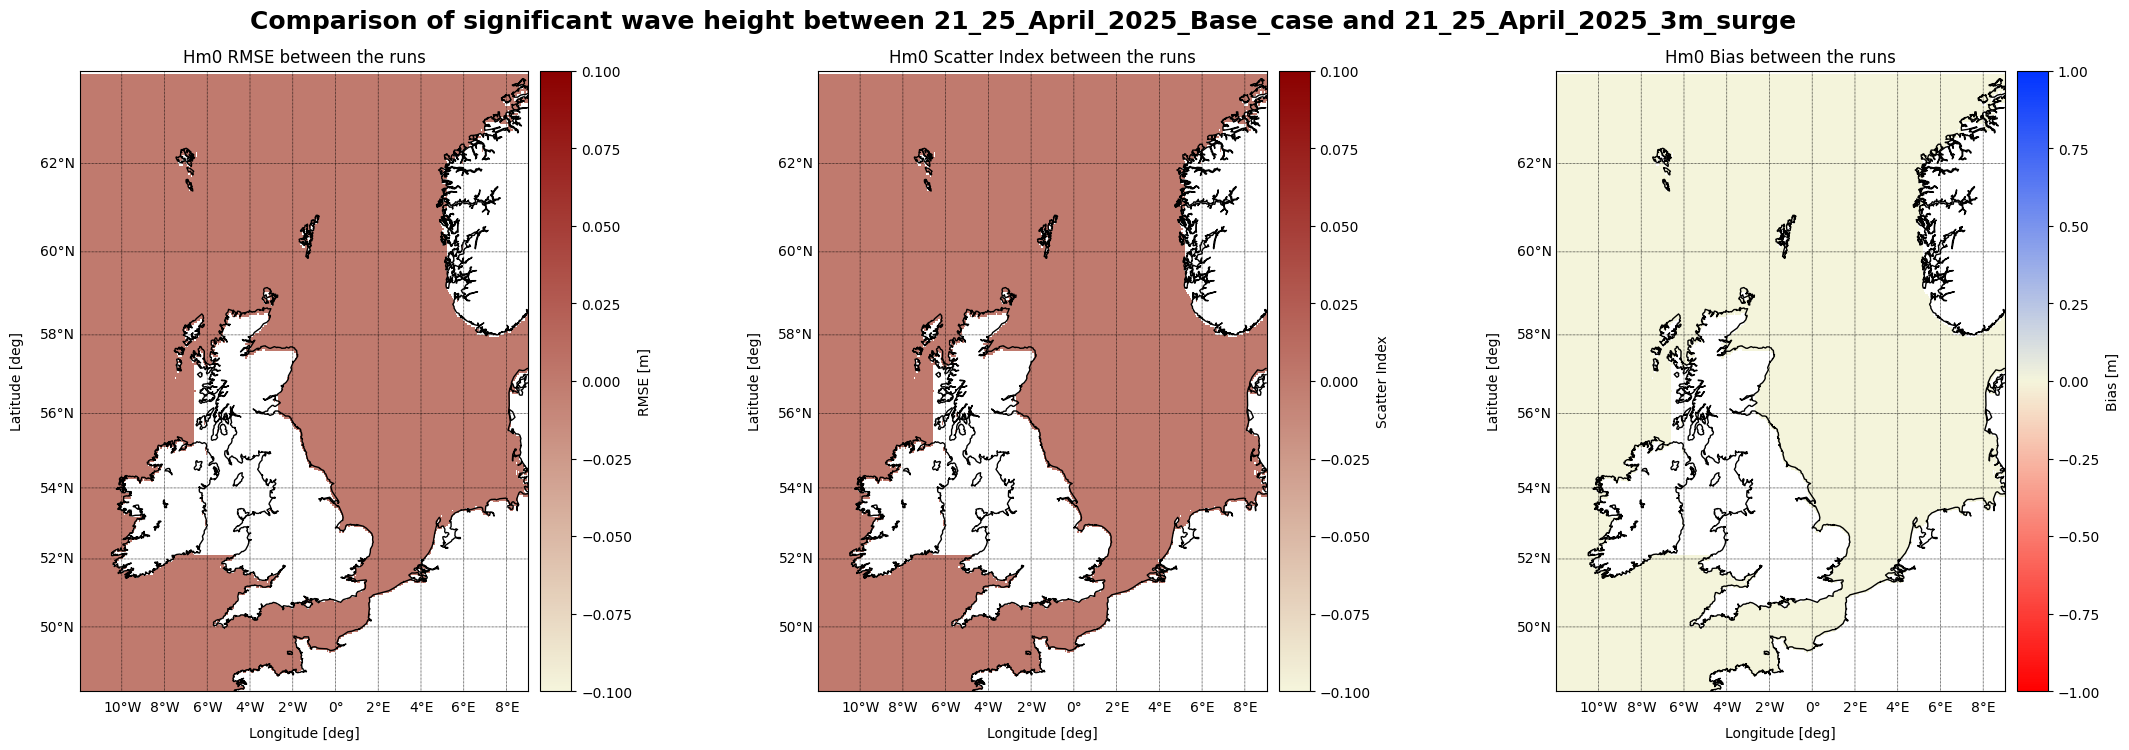

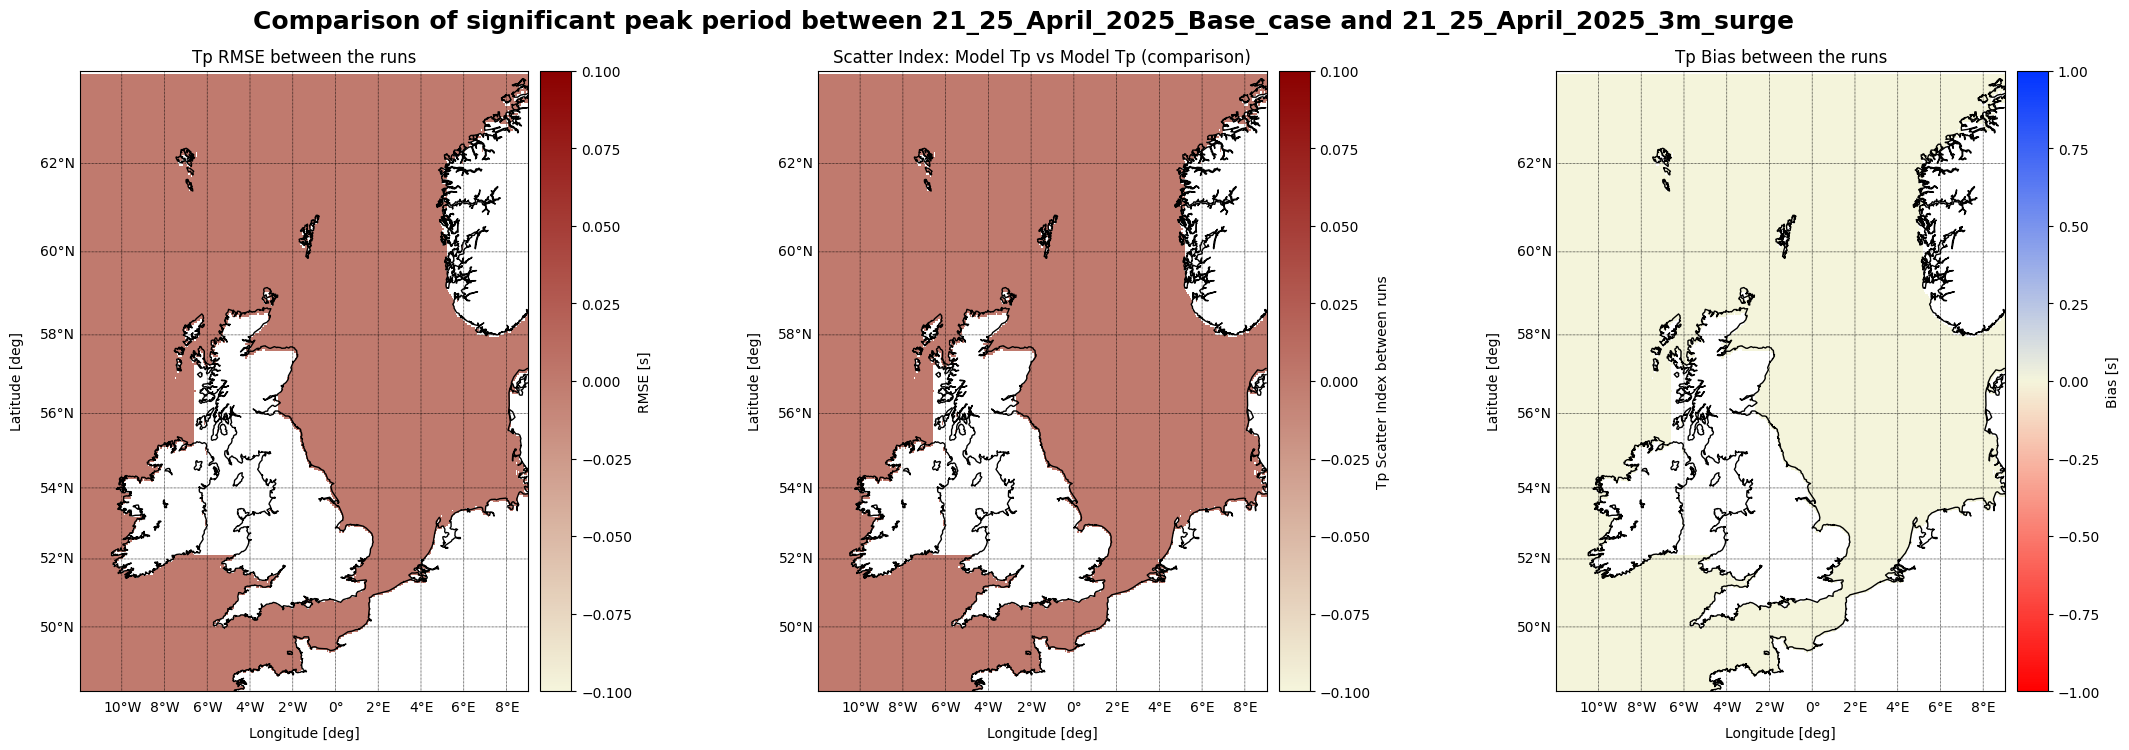

C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:53: RuntimeWarning: Mean of empty slice
  rmse_map_swh = np.sqrt(np.nanmean((comp_hm0 - base_hm0)**2, axis=0))
C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:54: RuntimeWarning: Mean of empty slice
  rmse_map_tp = np.sqrt(np.nanmean((comp_tp - base_tp)**2, axis=0))
C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:57: RuntimeWarning: Mean of empty slice
  scatter_index_map_swh = rmse_map_swh / np.nanmean(base_hm0, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:58: RuntimeWarning: Mean of empty slice
  scatter_index_map_tp = rmse_map_tp / np.nanmean(base_tp, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:61: RuntimeWarning: Mean of empty slice
  bias_map_swh = np.nanmean(comp_hm0 - base_hm0, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:62: RuntimeWarning: Mean of empty slice
  bias_map_tp = np.nanmean(comp_tp - base_tp, axis=0)


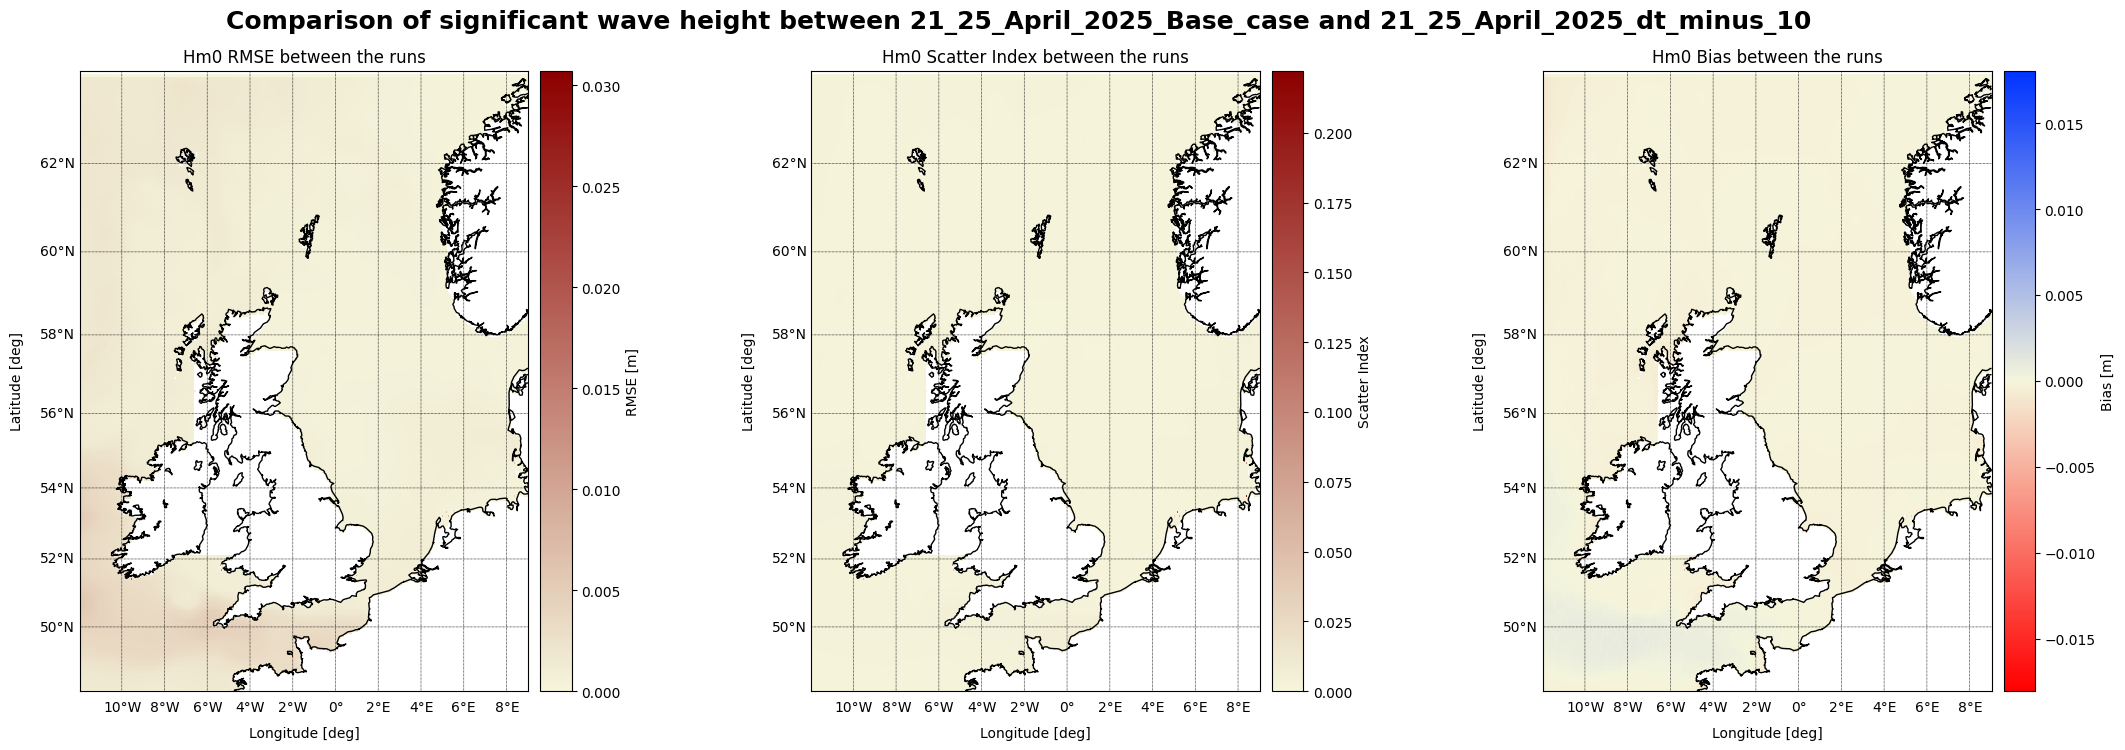

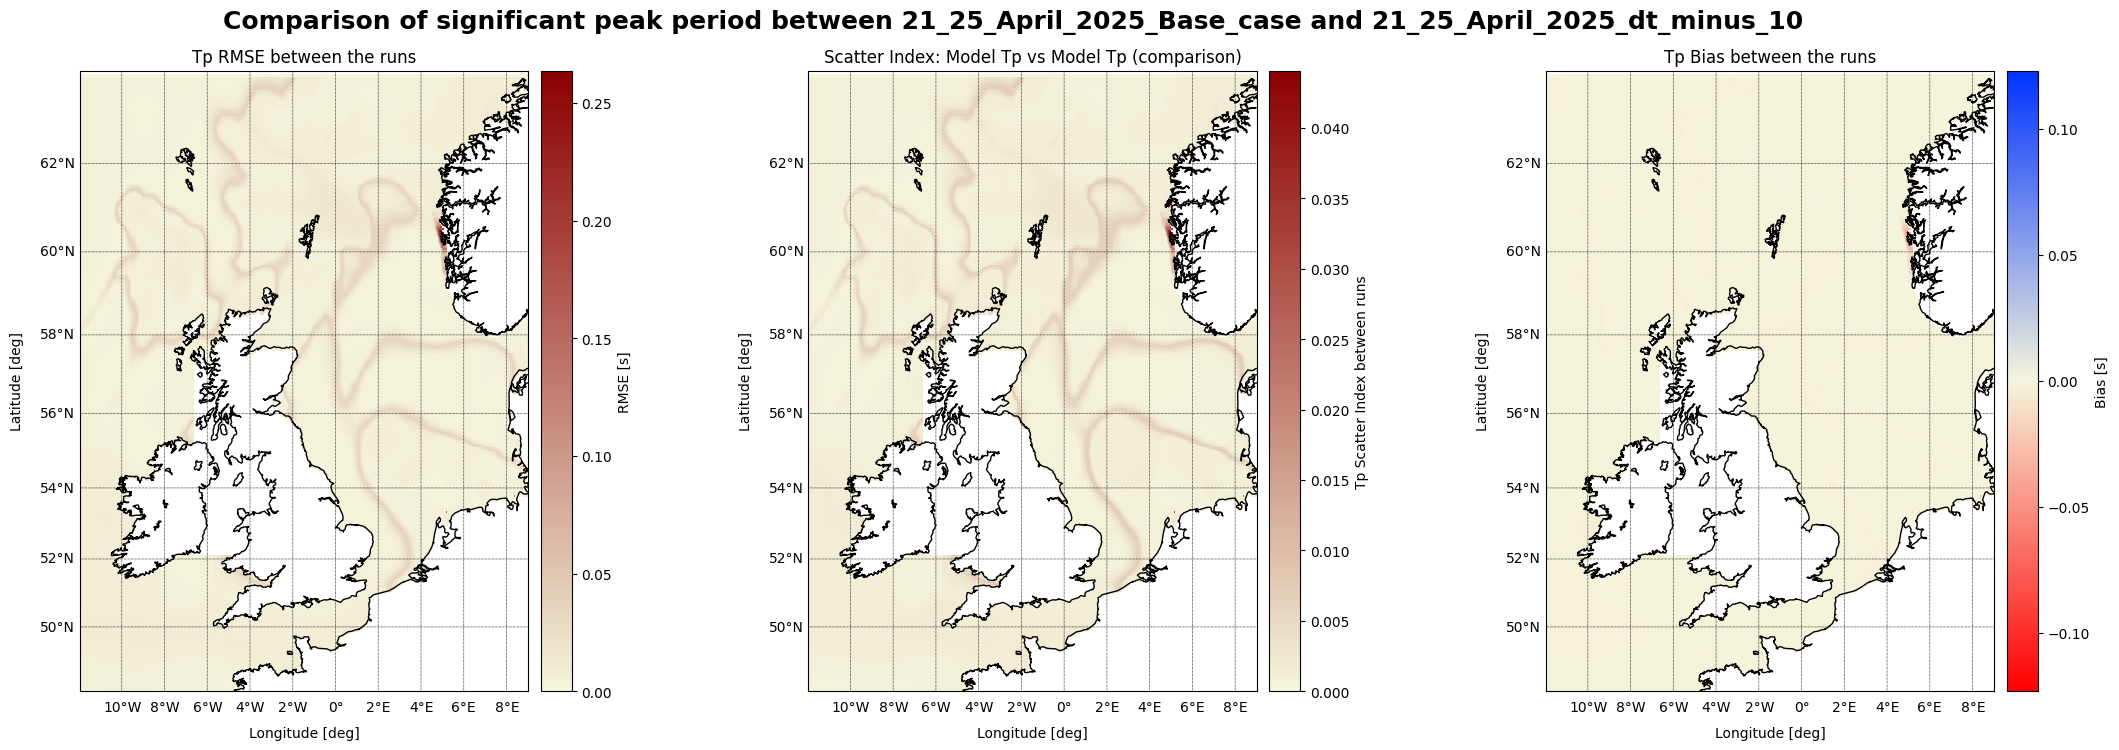

C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:53: RuntimeWarning: Mean of empty slice
  rmse_map_swh = np.sqrt(np.nanmean((comp_hm0 - base_hm0)**2, axis=0))
C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:54: RuntimeWarning: Mean of empty slice
  rmse_map_tp = np.sqrt(np.nanmean((comp_tp - base_tp)**2, axis=0))
C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:57: RuntimeWarning: Mean of empty slice
  scatter_index_map_swh = rmse_map_swh / np.nanmean(base_hm0, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:58: RuntimeWarning: Mean of empty slice
  scatter_index_map_tp = rmse_map_tp / np.nanmean(base_tp, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:61: RuntimeWarning: Mean of empty slice
  bias_map_swh = np.nanmean(comp_hm0 - base_hm0, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_7776\646433406.py:62: RuntimeWarning: Mean of empty slice
  bias_map_tp = np.nanmean(comp_tp - base_tp, axis=0)


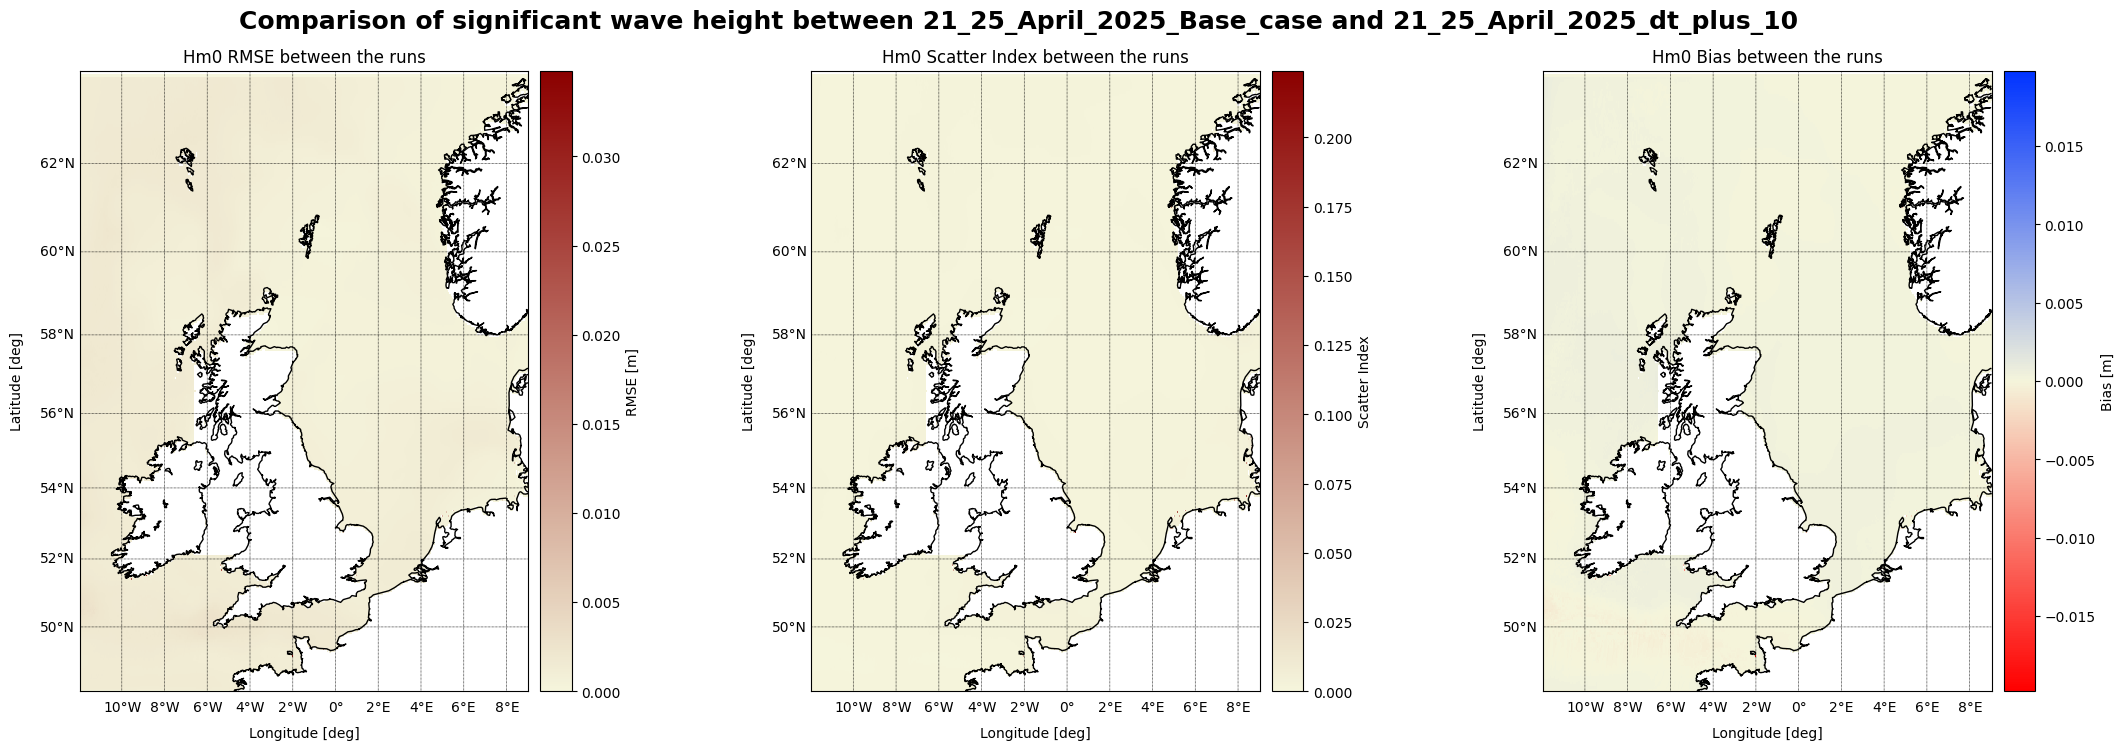

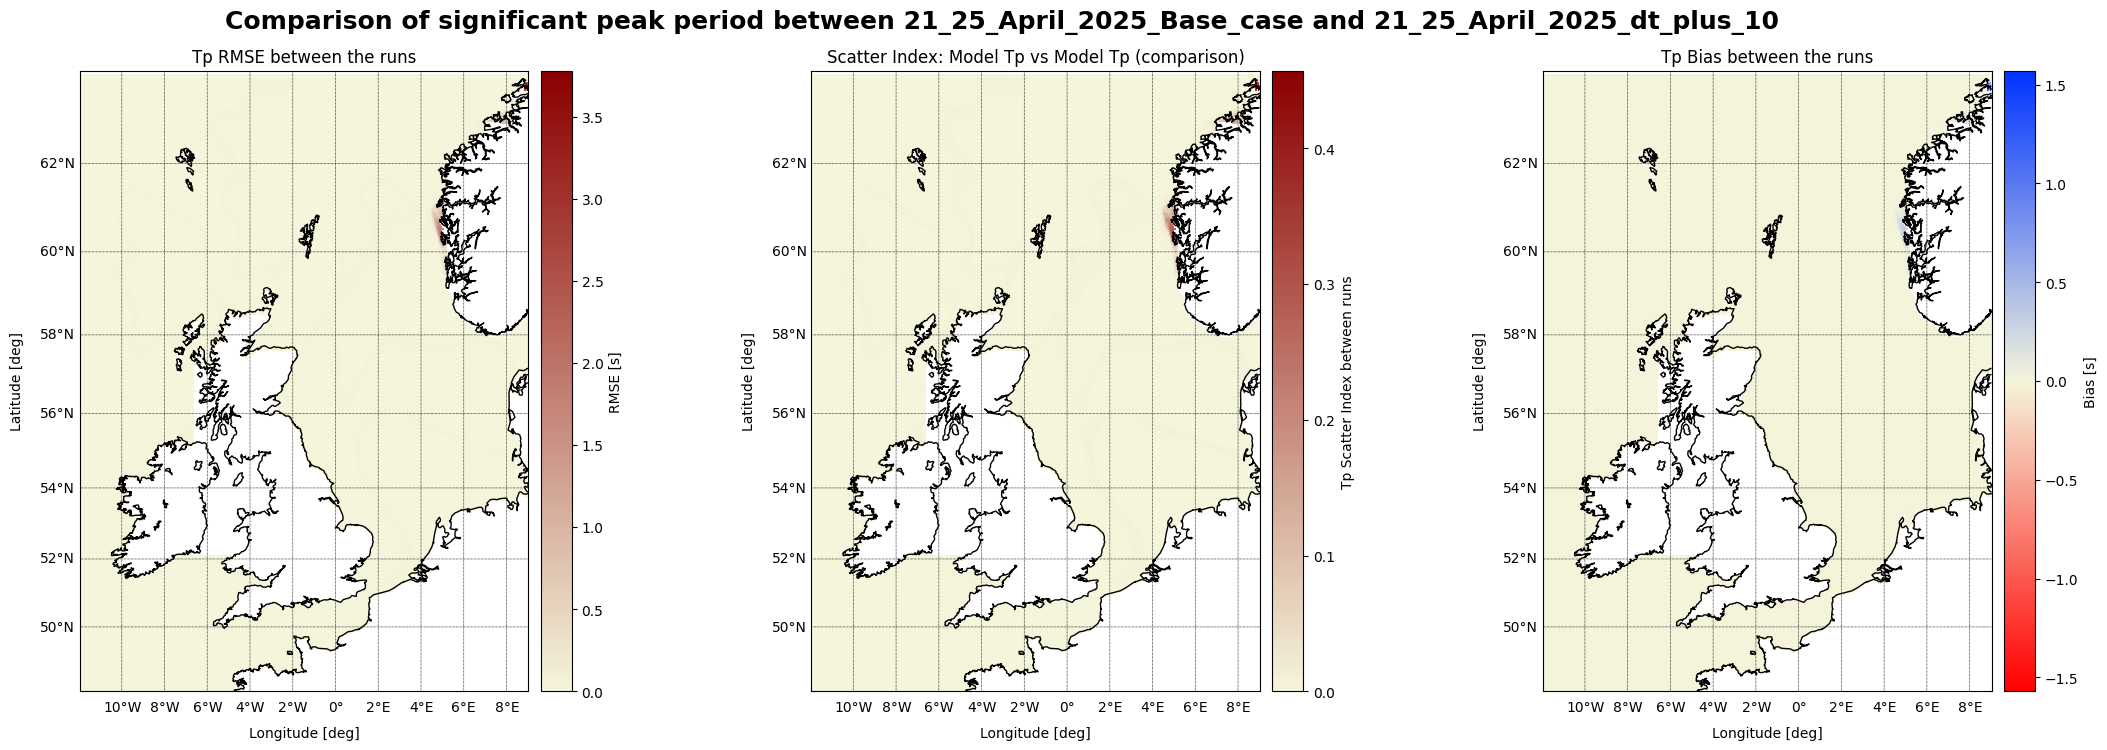

In [63]:
for path in map_filepaths[1:]:
    plot_comparison_map(map_filepaths[0], path, plot_swh=True, plot_tp=True)